In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

import string
import re

!pip install py_stringsimjoin
import py_stringsimjoin as ssj
!pip install py_stringmatching
import py_stringmatching as sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 2.1 MB/s 
     |████████████████████████████████| 661 kB 37.5 MB/s 
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.2-cp37-cp37m-linux_x86_64.whl size=3724191 sha256=f940e2bdd147bd4dd2f08ce6ced3e3b43756b2d04bab5b9ffd09618796845bf5
  Stored in directory: /root/.cache/pip/wheels/7c/0d/a4/c0a779a4d196bed8ed41ca12be09a93e158e4fc974b59f9fd5
  Created wheel for py-stringmatching: filename=py_stringmatching-0.4.2-cp37-cp37m-linux_x86_64.whl size=2055479 sha256=350a70fbe905550074071cc48a747773b4e61c182c32f13f93be779ef5c4f707
  Stored in directory: /root/.cache/pip/wheels/7e/12/86/46f9378ae730550dd2f89cad50880e70d66cabedd90074f2d2
Successfully built py-stringsimjoin py-stringmatching
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Introduzione

Questo notebook è quello fatto a lezione il 6 ottobre 2022, completato e rivisto soprattutto nella parte di Top Down Data Integration 

* N sorgenti (vecchia versione) : Questo esempio fatto in classe è stato rifatto alla fine dopo aver sintetizzato le funzioni, quindi considerare direttamente la nuova versione

* Considerare la nuova  sezione **Sintesi processo di Bottom-up Data Integration** 

* Quindi nella sezione **Funzioni per Data Integration** sono state raccolte (e a volte riviste e completate) tutte le strutture dati e funzioni per la Data Integration, suddividendole in 4 sottosezioni, dove
Funzioni generali e Valutazione,  si applicano ad entrambi gli scenari

* A breve verranno pubblicati anche alcuni esercizi


# Schema Matching

## to_sim_table e to_sim_matrix

In [2]:
def sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    A = pd.DataFrame({"A": TableA.columns})
    B = pd.DataFrame({"B": TableB.columns})
    S = A.assign(key=1).merge(B.assign(key=1), on="key").drop("key", axis=1)
    return S
    
def random_sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    S = sim_table(TableA, TableB)
    S["sim"] = np.random.rand(len(S))
    return S


def to_sim_table(SimMatrix:pd.DataFrame):
    return SimMatrix.stack().reset_index(name="sim")

def to_sim_matrix(SimTable:pd.DataFrame):
    return SimTable.pivot(index="A", columns="B", values="sim")

Come abbiamo detto, potete riscrivere queste funzioni;
ad esempio: il prodotto cartesiano può essere fatto senza il "trucco" 
di inserire una chiave comune di joi, ma tramite *how='cross'* come suggerito da MARCO MICHELINI durante la lezione:

In [3]:
def sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    A = pd.DataFrame({"A": TableA.columns})
    B = pd.DataFrame({"B": TableB.columns})
    S = A.merge(B, how='cross')
    return S

## string_preprocess e levenshtein_sim (label-based) 

In [4]:
def string_preprocess(s:str, char:str=string.punctuation, word:list=[]):
    if type(s) is str:
        s = s.lower()
        for c in char:
            s = s.replace(c, " ")
        for w in word:
            s = s.replace(w, " ")
    else:
        s = str(s)
    s = re.sub(" +", " ", s)
    return s.strip()

def levenshtein_sim(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["A"]),
            string_preprocess(row["B"])
        )

def levenshtein_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(levenshtein_sim, axis=1)
    return C.sort_values("sim", ascending=False)

def jaro_sim(row:pd.Series):
    jaro = sm.Jaro()
    return jaro.get_sim_score(
            string_preprocess(row["A"]),
            string_preprocess(row["B"])
        )

def jaro_label_based_similarity(TableA:pd.DataFrame,TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(jaro_sim, axis=1)                   
    return C

## Value Overlap: jaccard_value_overlap_sim e generalized_value_overlap_sim

In [5]:
def jaccard_sim(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame):
    j = sm.Jaccard()
    return j.get_raw_score(
            TableA[row["A"]].apply(string_preprocess).tolist(),
            TableB[row["B"]].apply(string_preprocess).tolist()
        )

def jaccard_value_overlap_sim(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(jaccard_sim, args=(TableA, TableB), axis=1)
    return C.sort_values("sim", ascending=False)

def generalized_sim(row:pd.Series, TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    j = sm.GeneralizedJaccard(
            sim_func=sm.Levenshtein().get_sim_score,
            threshold=threshold
        )
    return j.get_raw_score(
            TableA[row["A"]].apply(string_preprocess).tolist(),
            TableB[row["B"]].apply(string_preprocess).tolist()
        )

def generalized_value_overlap_sim(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(generalized_sim, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim", ascending=False)

## Value Overlap:   Extended Jaccard

In [6]:


#  funzione interna tramite Jaccard con WhitespaceTokenizer
def funzione_similarita_interna(row:pd.Series):
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["AX"])),
            tok.tokenize(string_preprocess(row["AY"])))

def funzione_similarita_interna(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )
    
def extend_jaccard_similarity(TX:pd.DataFrame, TY:pd.DataFrame, threshold:float):
    PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
    PCC["sim"] = PCC.apply(funzione_similarita_interna, axis=1)
    INTERSEZIONE =  PCC[PCC.sim>=threshold]
    SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
    SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))


## Value Overlap: String Similarity Join

In [7]:
def sim__join(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame, threshold:float):
    TX = TableA[[row["A"]]].applymap(string_preprocess).drop_duplicates()
    TY = TableB[[row["B"]]].applymap(string_preprocess).drop_duplicates()
    TX.columns=['AX']
    TY.columns=['AY']
    
    INTERSEZIONE  = ssj.jaccard_join(     TX, TY, # tabelle su cui effettuare il sim join
                                'AX', 'AY', # chiavi delle tabelle 
                                'AX', 'AY', # attributi di join
                                  sm.WhitespaceTokenizer(return_set=True),
                                  threshold=threshold, 
                                  show_progress=False,
                                  l_out_attrs=['AX'],  r_out_attrs=['AY']
                           )
    SoloInAX=TX.loc[~TX['AX'].isin(INTERSEZIONE['l_AX'])][['AX']].drop_duplicates()
    SoloInAY=TY.loc[~TY['AY'].isin(INTERSEZIONE['r_AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))


def value_overlap_simjoin_jaccard(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(sim__join, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim",ascending=False)

## Combined Approaches

Consideriamo l'approccio *Ensemble* che combina la predizione
di più SimTable in una unica SimTable ottenuta tramite
 avg(), min(), or max() 

In [8]:
def max_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B","sim"])
    for x in SimTableList:
        ST = ST.append(x, ignore_index=True)
    return ST.groupby(["A","B"])["sim"].max().reset_index()

def min_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B","sim"])
    for x in SimTableList:
        ST = ST.append(x, ignore_index=True)
    return ST.groupby(["A","B"])["sim"].min().reset_index()

def avg_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B",'sim'])
    for x in SimTableList:
        ST = ST.append(x, ignore_index=True)
    return ST.groupby(["A","B"])["sim"].mean().reset_index()

## Local Single Attribute Strategies

In [9]:
def thresholding(SimTable:pd.DataFrame, threshold:float):
    return SimTable[SimTable["sim"] > threshold].sort_values(["sim"], ascending=[False])
    
def top_K(SimTable:pd.DataFrame, K:int, AoB:str="A"):
    MT = deepcopy(SimTable)
    MT["pos"] = MT.sort_values(["sim"], ascending=[False]).groupby(AoB).cumcount()
    return MT[MT["pos"] < K].drop(columns=["pos"]).sort_values([AoB,"sim"], ascending=[True,False])

def top_1(SimTable:pd.DataFrame, AoB:str="A"):
    return top_K(SimTable, 1, AoB)

## Global Matching

Si considerano solo quelli *facili* da formulare, ovvero 
stable_marriage e simmetric_best_match

In [10]:
def stable_marriage(MatchTable:pd.DataFrame):
    MATCH = pd.DataFrame(columns=["A", "B", "sim"])
    MT = deepcopy(MatchTable)
    MT = MT.sort_values(["sim"], ascending=[False])
    while True:
        R = MT.loc[(~MT["A"].isin(MATCH["A"])) & (~MT["B"].isin(MATCH["B"]))]
        if len(R) == 0:
            break
        x = R.iloc[0,:]
        MATCH = MATCH.append(x, ignore_index=True)
    return MATCH

def simmetric_best_match(MatchTable:pd.DataFrame):
  CMT = deepcopy(MatchTable)

  CMT['A_RowNo'] = CMT.sort_values(['sim'], ascending=[False]) \
             .groupby(['A']) \
             .cumcount() + 1

  CMT['B_RowNo'] = CMT.sort_values(['sim'], ascending=[False]) \
             .groupby(['B']) \
             .cumcount() + 1

  return CMT[(CMT.A_RowNo==1) & (CMT.B_RowNo==1)].drop(columns=['A_RowNo', 'B_RowNo']).sort_values(['sim'], ascending=[False])

# Valutazione

In [11]:
def Valuta(Gold:pd.DataFrame, Match:pd.DataFrame):
    Match = Match[['A','B']]
    FOJ = Gold.merge(Match, how='outer', indicator=True)

    TP = FOJ[FOJ['_merge']=='both']
    FP = FOJ[FOJ['_merge']=='right_only']
    FN = FOJ[FOJ['_merge']=='left_only']

    if len(TP) == 0:
        return pd.DataFrame({
                'MT':[len(Match)],
                'TP':[len(TP)],
                'FP':[len(FP)],
                'FN':[len(FN)],
                'P':[round(0,4)],
                'R':[round(0,4)],
                'F':[round(0,4)]
            })
    else:
        P = len(TP)/(len(TP)+len(FP))
        R = len(TP)/(len(TP)+len(FN))
        F = 2 * P * R / ( P + R )
        return pd.DataFrame({
                'MT':[len(Match)],
                'TP':[len(TP)],
                'FP':[len(FP)],
                'FN':[len(FN)],
                'P':[round(P,4)],
                'R':[round(R,4)], 
                'F':[round(F,4)]
            })

def Vedi_Valuta(Gold:pd.DataFrame, Match:pd.DataFrame, metrics:str):
    Match=Match[['A','B']]
    FOJ=pd.merge(Gold, Match, how='outer', indicator=True)

    TP=FOJ[FOJ['_merge']=='both']
    FP=FOJ[FOJ['_merge']=='right_only']
    FN=FOJ[FOJ['_merge']=='left_only']

    if metrics == 'FP' :
        return FP
    if metrics == 'TP' :
        return TP
    if metrics == 'FN' :
        return FN

# Top-Down Data Integration

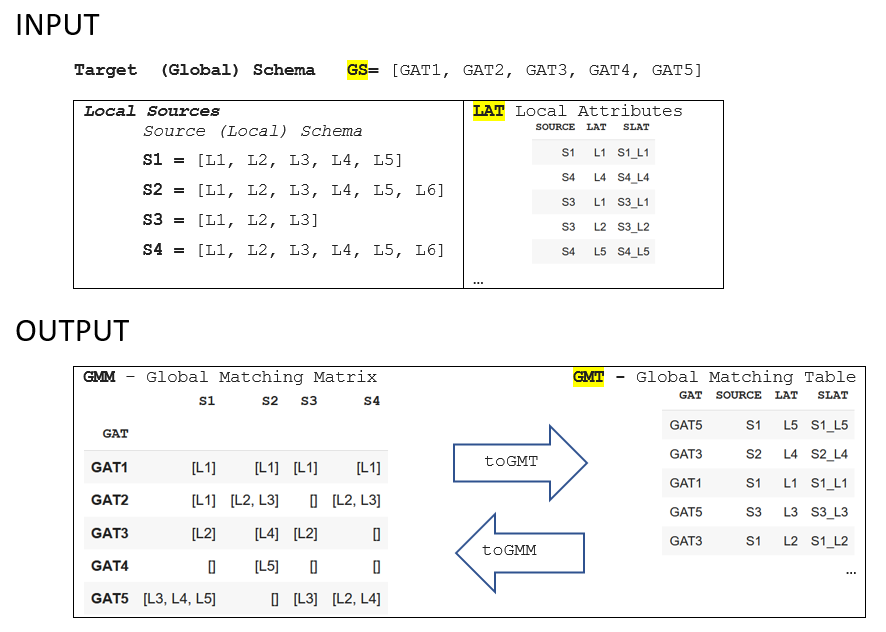



## Esempio Simbolico

Per spiegare questi concetti, consideriamo un Global schema GS e una Global Matching Table simboliche già date

In [12]:
# Esempio simbolico
GS= ['GAT1', 'GAT2', 'GAT3', 'GAT4','GAT5']
GMM = pd.DataFrame({'GAT': GS,
'S1': [['L1'],['L1'],['L2'],[],['L3','L4','L5']] ,
'S2': [['L1'],['L2','L3'],['L4'],['L5'],[]] ,
'S3': [['L1'],[],['L2'],[],['L3']] ,
'S4': [['L1'],['L2','L3'],[],[],['L2','L4']] 
})
GMM=GMM.set_index(['GAT'])

GMM

,S1,S2,S3,S4
GAT,,,,
GAT1,[L1],[L1],[L1],[L1]
GAT2,[L1],"[L2, L3]",[],"[L2, L3]"
GAT3,[L2],[L4],[L2],[]
GAT4,[],[L5],[],[]
GAT5,"[L3, L4, L5]",[],[L3],"[L2, L4]"


In [13]:
def to_GMT(MT):
  GMT = pd.DataFrame(columns=['GAT','SOURCE', 'LAT','SLAT'])

  for x in MT.index:
    for y in MT.columns:
      for z in MT.loc[x][y]:
        GMT.loc[len(GMT)]=[x,y,z,str(y)+ '_' + z]
  return GMT

In [14]:
to_GMT(GMM)

,GAT,SOURCE,LAT,SLAT
0,GAT1,S1,L1,S1_L1
1,GAT1,S2,L1,S2_L1
2,GAT1,S3,L1,S3_L1
3,GAT1,S4,L1,S4_L1
4,GAT2,S1,L1,S1_L1
5,GAT2,S2,L2,S2_L2
6,GAT2,S2,L3,S2_L3
7,GAT2,S4,L2,S4_L2
8,GAT2,S4,L3,S4_L3
9,GAT3,S1,L2,S1_L2


In [15]:
# con .fillna("[]")
def to_GMM(GMTA:pd.DataFrame):
    return GMTA.groupby(['GAT','SOURCE'])['LAT'].agg(list).unstack('SOURCE').fillna("[]")
# "funziona" to_GMM(to_GMT(GMM))
# ma non to_GMM(to_GMT(GMM))
#
# quindi usiamo 
def to_GMM(GMTA:pd.DataFrame):
    df = GMTA.groupby(['GAT','SOURCE'])['LAT'].agg(list).unstack('SOURCE')
    for c in df.columns:
        df.loc[df[c].isnull(), [c]] = df.loc[df[c].isnull(), c].apply(lambda x: [])
    return df

In [16]:
M=to_GMM(to_GMT(GMM))
M

SOURCE,S1,S2,S3,S4
GAT,,,,
GAT1,[L1],[L1],[L1],[L1]
GAT2,[L1],"[L2, L3]",[],"[L2, L3]"
GAT3,[L2],[L4],[L2],[]
GAT4,[],[L5],[],[]
GAT5,"[L3, L4, L5]",[],[L3],"[L2, L4]"


In [17]:
to_GMT(M)

,GAT,SOURCE,LAT,SLAT
0,GAT1,S1,L1,S1_L1
1,GAT1,S2,L1,S2_L1
2,GAT1,S3,L1,S3_L1
3,GAT1,S4,L1,S4_L1
4,GAT2,S1,L1,S1_L1
5,GAT2,S2,L2,S2_L2
6,GAT2,S2,L3,S2_L3
7,GAT2,S4,L2,S4_L2
8,GAT2,S4,L3,S4_L3
9,GAT3,S1,L2,S1_L2


In [18]:
to_GMT(to_GMM(to_GMT(GMM)))

,GAT,SOURCE,LAT,SLAT
0,GAT1,S1,L1,S1_L1
1,GAT1,S2,L1,S2_L1
2,GAT1,S3,L1,S3_L1
3,GAT1,S4,L1,S4_L1
4,GAT2,S1,L1,S1_L1
5,GAT2,S2,L2,S2_L2
6,GAT2,S2,L3,S2_L3
7,GAT2,S4,L2,S4_L2
8,GAT2,S4,L3,S4_L3
9,GAT3,S1,L2,S1_L2


## Global Schema

Verranno considerati due casi

1.   **Empty Global Schema** : e' il caso base, in cui viene dato come input al problema solo lo *schema globale vuoto* (senza istanze) che si vuole ottenere 

2.   **Instanced  Global Schema** : si suppone di avere anche alcune istanze dello schema globale; questo in pratica avviene in un processo di integrazione incrementale, in cui si parte da un Empty Global Schema, si integrano alcune sorgenti e quindi si trasferiscono le istanze allo schema globale. Si procede quindi integrando le altre sorgenti.

In [19]:
# ESEMPIO
# Instanced Global Schema 
GlobalSchema=pd.read_csv("https://dbgroup.ing.unimore.it/SIWS/E1/GlobalSchema.csv").astype(str) 

# Empty Global Schema : è lo stesso schema senza istanze
EmptyGlobalSchema=GlobalSchema[0:0]
EmptyGlobalSchema

,rec_id,Name,Surname,Main Work Address (City),Main Work Address (Phone),Secondary_Work_Address_City_Phone,Phone4City3,Other Phone,Age1,Age2,Age4


In [20]:
GlobalSchema.head()

,rec_id,Name,Surname,Main Work Address (City),Main Work Address (Phone),Secondary_Work_Address_City_Phone,Phone4City3,Other Phone,Age1,Age2,Age4
0,rec-00-org,jessica,coppinger,reno,04 4677 9481,oklahoma 429 897 3783,(406) 375-8269 newark,(742) 798-8494,52,21,67
1,rec-01-org,ella,butt,jacksonville,02 6802 5127,newark 298 268 6152,(885) 622-7357 newark,(638) 641-9249,84,32,71
2,rec-02-org,eliza,white,san francisco,02 2178 7500,newark 272 123 7538,(233) 919-4516 newark,(627) 272-3605,45,30,71
3,rec-03-org,alexander,bristow,newark,03 2485 8747,memphis 145 019 2612,(446) 237-1160 newark,(314) 044-7561,49,27,73
4,rec-04-org,lauren,britten,newark,02 8917 0810,newark 230 564 4025,(272) 901-4673 lubbock,(461) 124-3130,71,46,71


##  Local Sources : SOURCES & **LAT**

In [21]:
SOURCES={}
SOURCES['S1']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S1.csv').astype(str)
SOURCES['S2']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S2.csv').astype(str)
SOURCES['S3']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S3.csv').astype(str)

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES.keys():
    for y in SOURCES[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]

In [ ]:
# Oppure
src_links = [
 'https://dbgroup.ing.unimore.it/SIWS/E1/S1.csv',
 'https://dbgroup.ing.unimore.it/SIWS/E1/S2.csv',
 'https://dbgroup.ing.unimore.it/SIWS/E1/S3.csv']

SOURCES = { 'S'+str(i+1) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

data = [[name,col, name+'_'+col] for name, df in SOURCES.items() for col in df.columns]
LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'],data=data)

In [ ]:
SOURCES['S2'].head()

,rec_id,Nome Completo,City2,Phone1,Age1,Age3,City3,Sex,Sex2,gender,gender2,X1,X3
0,rec-35-org,jacob reid,newark,03 0373 8067,50,33,newark,m,28435.25,female,widowed,melbourne,126.075
1,rec-36-org,lexie lowe,newark,04 6936 7343,85,31,chicago,f,101028.87,female,single,sydney,112.181
2,rec-37-org,yasmin coleman,newark,03 9156 4619,87,27,newark,f,170319.486,female,married_spouce_present,sydney,112.405
3,rec-38-org,garth newey,newark,07 4065 7131,51,23,newark,m,87334.245,female,divorced,sydney,163.461
4,rec-39-org,catherine van der vlies,newark,02 7954 5346,63,34,houston,m,68747.00200000001,male,married_spouce_present,melbourne,110.565


### Gold Standard

In [22]:
GoldStandard=pd.read_csv("https://dbgroup.ing.unimore.it/SIWS/E1/GoldStandardEsempioE1.csv").astype(str) 
GoldStandard

,GAT,SOURCE,LAT,SLAT
0,rec_id,S1,rec_id,S1_rec_id
1,rec_id,S2,rec_id,S2_rec_id
2,rec_id,S3,rec_id,S3_rec_id
3,Name,S1,Name,S1_Name1
4,Name,S2,Full Name,S2_Nome Completo
5,Name,S3,Full Name,S3_Nome Completo
6,Surname,S1,Surname,S1_Name2
7,Surname,S2,Full Name,S2_Nome Completo
8,Surname,S3,Full Name,S3_Nome Completo
9,Main Work Address (City),S1,City,S1_City1


In [23]:
to_GMM(GoldStandard)

SOURCE,S1,S2,S3
GAT,,,
Age1,[Age1],[Age1],[]
Age2,[Age2],[],[Age2]
Age4,[],[],[Age4]
Main Work Address (City),[City],[],[City1]
Main Work Address (Phone),[],[Phone1],[Phone1]
Name,[Name],[Full Name],[Full Name]
Other Phone,[Phone3],[],[Phone3]
Phone4City3,[Phone4],[City3],"[City3, Phone4]"
Secondary_Work_Address_City_Phone,[Phone2],[City2],[City2]


In [24]:
GoldStandard.sample(5)

,GAT,SOURCE,LAT,SLAT
8,Surname,S3,Full Name,S3_Nome Completo
3,Name,S1,Name,S1_Name1
10,Main Work Address (City),S3,City1,S3_City1
11,Main Work Address (Phone),S2,Phone1,S2_Phone1
2,rec_id,S3,rec_id,S3_rec_id


Per effettuare la valutazione useremo la coppia **(GAT,SLAT)** che verrà confrontata con quanto ottenuto dal Matching.

La seguente funziona rinomina  **(GAT,SLAT)** come **(A,B)**.

IMPORTANTE : RICORDARSI CHE il global attribut è nella prima posizione A e che il local attribute è nella posizione B;
comunque questo si intuisce anche dai nomi in quanto il local attribute ha come prefisso il nome della sorgente

In [25]:
def toA_B(Y):
  X=Y[['GAT','SLAT']].rename(columns={'GAT':'A','SLAT':'B'})
  return X

In [26]:
toA_B(GoldStandard.sample(5))

,A,B
18,Phone4City3,S3_City3
26,Age4,S3_Age4
15,Secondary_Work_Address_City_Phone,S3_City2
8,Surname,S3_Nome Completo
20,Other Phone,S1_Phone3


Nel seguito mostriamo come calcolare  la Global Matching Table **GMT**, che verrà poi visualizzata come Matrix.

## CALCOLO  **GMT**

Un  Matching Method tra due schemi  A e B è  applicato n volte tra il Global Schema GS e le source Si (Local Schema)


Questo è il modo più semplice di procedere; si potrebbe differenziare il Matching Method (cioè il calcolo della SimTable) per ciascuna coppia GlobalSchema, Local Schema

In [27]:
SOURCES['S1'].head()

,rec_id,Name1,Name2,City1,Phone2,Phone3,Phone4,Age1,Age2,Sex,gender2,X1,X2
0,rec-90-org,liam,smallacombe,jacksonville,572 616 7704,(860) 780-9762,(357) 265-5969,83,83,na,married_spouce_present,sydney,m
1,rec-08-org,madeline,white,las vegas,136 404 3378,(556) 680-3377,(360) 010-3150,89,89,na,single,sydney,f
2,rec-48-org,eleanor,verner,newark,308 519 6891,(324) 117-8984,(828) 194-4716,53,53,m,married_spouce_present,sydney,f
3,rec-37-org,yasmin,coleman,newark,993 647 1075,(594) 048-1047,(105) 098-4805,87,87,f,married_spouce_present,sydney,m
4,rec-32-org,erin,singleton,newark,355 979 4686,(709) 100-8137,(554) 602-4121,46,46,f,married_spouce_present,hobart,m


In [28]:
def CalcoloGlobalMatchingTable(Sources:list, GlobalSchema:pd.DataFrame):
    GlobalMatchingTable = pd.DataFrame(columns=['GAT','SOURCE','LAT','SLAT','sim'])
    from tqdm import tqdm
    for y in tqdm(Sources.keys()):
        SimTableA = levenshtein_label_based_similarity(GlobalSchema, Sources[y])
        SimTableB = jaro_label_based_similarity(GlobalSchema, Sources[y])
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=value_overlap_simjoin_jaccard(GlobalSchema, Sources[y], 0.5)

        # combiner
        # SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])
    
        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.6)

        #MatchTable = top_K(SimTable,2)
        #MatchTable = top_K(MatchTable,2)
        
         # global mapping
        #MatchTable = stable_marriage(MatchTable)
#        MatchTable = simmetric_best_match(MatchTable)
     
        MatchTable.columns = ['GAT','LAT','sim']
        MatchTable['SOURCE'] = str(y)
        MatchTable['SLAT'] = MatchTable['SOURCE']+'_'+MatchTable['LAT']
        GlobalMatchingTable = GlobalMatchingTable.append(MatchTable, sort=False)
    return GlobalMatchingTable

In [29]:
GMT=CalcoloGlobalMatchingTable(SOURCES,EmptyGlobalSchema)
GMT

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])
100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


,GAT,SOURCE,LAT,SLAT,sim
0,Age1,S1,Age1,S1_Age1,1.000000
14,Age2,S1,Age2,S1_Age2,1.000000
142,rec_id,S1,rec_id,S1_rec_id,1.000000
69,Name,S1,Name2,S1_Name2,0.933333
68,Name,S1,Name1,S1_Name1,0.933333
98,Phone4City3,S1,Phone4,S1_Phone4,0.848485
26,Age4,S1,Age1,S1_Age1,0.833333
27,Age4,S1,Age2,S1_Age2,0.833333
1,Age1,S1,Age2,S1_Age2,0.833333
13,Age2,S1,Age1,S1_Age1,0.833333


In [30]:
to_GMM(GMT)

SOURCE,S1,S2,S3
GAT,,,
Age1,"[Age1, Age2, Name1, Name2]","[Age1, Age3, Phone1, gender]","[Age4, Age2, gender, Phone1]"
Age2,"[Age2, Age1, Name2, Name1, Phone2]","[Age1, Age3, Sex2, gender]","[Age2, Age4, Sex2, gender]"
Age4,"[Age1, Age2, Name2, Name1, Phone4]","[Age3, Age1, gender]","[Age4, Age2, gender, Phone4]"
Name,"[Name2, Name1, Age1, Age2]","[Age1, Age3, Nome Completo]","[Age2, Age4, Nome Completo]"
Other Phone,[],[Nome Completo],[Nome Completo]
Phone4City3,"[Phone4, Phone3, Phone2]",[Phone1],"[Phone4, Phone1, Phone3]"
rec_id,[rec_id],[rec_id],[rec_id]


In [31]:
GMT=CalcoloGlobalMatchingTable(SOURCES,EmptyGlobalSchema)
Valuta(toA_B(GoldStandard),toA_B(GMT))

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])
100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


,MT,TP,FP,FN,P,R,F
0,59,13,46,14,0.2203,0.4815,0.3023


In [32]:
X=CalcoloGlobalMatchingTable(SOURCES,EmptyGlobalSchema)
Valuta(toA_B(GoldStandard),toA_B(X))

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])
100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


,MT,TP,FP,FN,P,R,F
0,59,13,46,14,0.2203,0.4815,0.3023


# Esempio reale : Movie dataset

Si considerano alcuni dataset disponibili in Magellan

https://sites.google.com/site/anhaidgroup/useful-stuff/the-magellan-data-repository


(oppure 
[http://pages.cs.wisc.edu/~anhai/data/784_data/](http://pages.cs.wisc.edu/~anhai/data/784_data/))


Ogni dataset, quale ad esempio *movie5* 
```
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/roger_ebert.csv', 
```

è costituito da due file csv utilizzati per il processo di Entity Resolution del corso di  Anhai Doan (si noti infatti che tra i file forniti c'è anche un labelled_data che verrà usato per l'Entity Resolution basata su Machine Learning).

Questi due dataset dello stesso progetto movie5, 
sono di fonti differenti (imdb e roger_ebert) ma comunque sono stati scelti in modo da avere delle sovrapposizioni, cioè uno stesso film presente in entrambi. Questa è una considerazione importante, in quanto si  può supporre che tra alcune coppie di attributi dei due differenti file ci sia un overlap che possiamo sfruttare nei metodi di Instance-based schema matching : Value Overlap


D'altra parte si nota che la stessa fonte, ad esempio imdb, è utilizzata 
in differenti dataset/progetti movie5, movie3, movie1

```
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies3/csv_files/imdb.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/imdb.csv']
```

Gli attributi e le istanze sono differenti,


```
movie 5 Source: IMDB                                                             
    Number of records: 6913                                                    
    Attributes: [id, movie_name, year, directors, actors, movie_rating, genre,
                 duration]

movie 3     Source: IMDB                                                  
    Number of records: 2960                                                     
    Attributes: [ID, Title, Year, Rating, Director, Creators, Cast, Genre,
                 Duration, ContentRating, Summary]  

```


ma anche qui si può ipotizzare una certa sovrapposizione essendo la stessa fonte.

In definitiva, in questo esempio l'applicazione dei metodi di schema matching basati sulle istanze sembra essere promettente;
d'altra parte verificheremo i metodi introdotti, anche quello basato sul similarity join, richiedono un tempo di esecuzione considerevole.

Per questo motivo, il passo successivo sara' quello di introdurre un nuovo metodo sempre basato sulle istanze ma che usa tecniche di machine learning

In [ ]:
src_links = [
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/roger_ebert.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/rotten_tomatoes.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies3/csv_files/rotten_tomatoes.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies4/csv_files/amazon.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies3/csv_files/imdb.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/imdb.csv']

SOURCES = { 'S'+str(i+1) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

GoldStandard=pd.read_csv('http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Movie_MTGS.csv')

In [ ]:
to_GMM(GoldStandard)

SOURCE,0,1,2,3,4,5,6
GAT,,,,,,,
Filming_Locations,NaN,NaN,[Filming Locations],NaN,NaN,NaN,NaN
Id,NaN,NaN,[Id],NaN,NaN,NaN,[Id]
RatingCount,NaN,NaN,[RatingCount],NaN,NaN,NaN,NaN
ReviewCount,NaN,NaN,[ReviewCount],NaN,NaN,NaN,NaN
movie_ContentRating,NaN,[pg_rating],NaN,[ContentRating],NaN,[ContentRating],[ContentRating]
movie_cast,[actors],[actors],"[Actors, Cast]",[Cast],[star],[Cast],[Cast]
movie_cost,NaN,NaN,NaN,NaN,[cost],NaN,NaN
movie_country,NaN,NaN,[Country],NaN,NaN,NaN,NaN
movie_creators,NaN,NaN,[Creator],[Creators],NaN,[Creators],[Creator]


Nel GoldStandard questa volta le source sono indicate con 0,1,2 invece che con S1,S2, S3, ...

quindi cambiamo le chiavi del dizionario SOURCES

In [ ]:
src_links = [
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/roger_ebert.csv', 
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/rotten_tomatoes.csv']

In [ ]:
SOURCES = { str(i) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }
#SOURCES = { i : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

In [ ]:
SOURCES['2'].head()

,Id,Name,Year,Release Date,Director,Creator,Actors,Cast,Language,Country,Duration,RatingValue,RatingCount,ReviewCount,Genre,Filming Locations,Description
0,tt0054215,Psycho,1960,8 September 1960 (USA),Alfred Hitchcock,"Joseph Stefano,Robert Bloch","Anthony Perkins,Janet Leigh,Vera Miles","Anthony Perkins,Vera Miles,John Gavin,Janet Leigh,Martin Balsam,John McIntire,Simon Oakland,Fran...",English,USA,109 min,8.6,"379,998","976 user,290 critic","Horror,Mystery,Thriller","Title and Trust Building, 114 West Adams Street, downtown Phoenix, Arizona, USA","A Phoenix secretary steals $40,000 from her employer's client, goes on the run and checks into a..."
1,tt0088993,Day of the Dead,1985,19 July 1985 (USA),George A. Romero,George A. Romero,"Lori Cardille,Terry Alexander,Joseph Pilato","Lori Cardille,Terry Alexander,Joseph Pilato,Jarlath Conroy,Anthony Dileo Jr.,Richard Liberty,She...",English,USA,96 min,7.2,"46,421","414 user,177 critic","Action,Drama,Horror","Sanibel Island, Florida, USA",A small group of military officers and scientists dwell in an underground bunker as the world ab...
2,tt0032484,Foreign Correspondent,1940,16 August 1940 (USA),Alfred Hitchcock,"Charles Bennett,Joan Harrison","Joel McCrea,Laraine Day,Herbert Marshall","Joel McCrea,Laraine Day,Herbert Marshall,George Sanders,Albert Bassermann,Robert Benchley,Edmund...","English,Dutch,Latvian",USA,120 min,7.6,"12,684","124 user,73 critic","Romance,Thriller,War","Hotel de l'Europe, Nieuwe Doelenstraat 2-14, Amsterdam, Netherlands","On the eve of WWII, a young American reporter tries to expose enemy agents in London."
3,tt0889671,Trumbo,2007,27 June 2008 (USA),Peter Askin,"Christopher Trumbo,Christopher Trumbo","Dalton Trumbo,Joan Allen,Brian Dennehy","Dalton Trumbo,Joan Allen,Brian Dennehy,Michael Douglas,Paul Giamatti,Nathan Lane,Josh Lucas,Liam...",English,USA,96 min,7.5,724,"14 user,33 critic","Documentary,Biography",nan,"Through a focus on the life of Dalton Trumbo (1905-1976), this film examines the effects on indi..."
4,tt1325014,The People vs. George Lucas,2010,29 August 2011 (USA),Alexandre O. Philippe,Alexandre O. Philippe,"Joe Nussbaum,Daryl Frazetti,Doug Jones","Joe Nussbaum,Daryl Frazetti,Doug Jones,Damian Hess,Richie Mehta,Brian Comerford,Dale Pollock,Gle...","English,French","USA,UK",93 min,6.7,"3,341","27 user,49 critic","Documentary,Comedy","Geneva, Canton de Genève, Switzerland",An examination of the widespread fan disenchantment with George Lucas.


In [ ]:
GoldStandard=pd.read_csv('http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Movie_MTGS.csv')
GoldStandard['SOURCE']=GoldStandard['SOURCE'].apply(str)

In [ ]:
# simuliamo come schema globale EMPTY uno schema con tutti gli attributi che hai nel GoldStandard
# 
ListOfGAT=GoldStandard['GAT'].drop_duplicates().to_list()
EmptyGlobalSchema = pd.DataFrame(columns=ListOfGAT)
EmptyGlobalSchema

,Filming_Locations,RatingCount,ReviewCount,movie_country,movie_genre,movie_duration,movie_ContentRating,movie_year,movie_rating,Id,movie_title,movie_date,movie_director,movie_creators,movie_cast,movie_language,movie_url,movie_time,movie_cost,movie_summary


In [ ]:
# per vedere gli attributi di una sorgente locale
print(SOURCES['1'].columns.to_list())

['id', 'movie_name', 'year', 'directors', 'actors', 'critic_rating', 'genre', 'pg_rating', 'duration']


In [ ]:
def CalcoloGlobalMatchingTable(Sources:list, GlobalSchema:pd.DataFrame):
    GlobalMatchingTable = pd.DataFrame(columns=['GAT','SOURCE','LAT','SLAT','sim'])
    from tqdm import tqdm
    for y in tqdm(Sources.keys()):
        SimTableA = levenshtein_label_based_similarity(GlobalSchema, Sources[y])
        SimTableB = jaro_label_based_similarity(GlobalSchema, Sources[y])
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        # SimTableC=value_overlap_simjoin_jaccard(GlobalSchema, Sources[y], 0.5)

        # combiner
        # SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        SimTable = max_sim_table([SimTableA,SimTableB])
    
        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.7)

        #MatchTable = top_K(SimTable,2)
        #MatchTable = top_K(MatchTable,2)
        
         # global mapping : rende le corrispondenze tra i due schemi di tipo 1-1
#        MatchTable = stable_marriage(MatchTable)
        MatchTable = simmetric_best_match(MatchTable)
     
        MatchTable.columns = ['GAT','LAT','sim']
        MatchTable['SOURCE'] = str(y)
        MatchTable['SLAT'] = MatchTable['SOURCE']+'_'+MatchTable['LAT']
        GlobalMatchingTable = GlobalMatchingTable.append(MatchTable, sort=False)
    return GlobalMatchingTable

In [ ]:
CalcoloGlobalMatchingTable(SOURCES, EmptyGlobalSchema)

100%|██████████| 3/3 [00:00<00:00, 20.46it/s]


,GAT,SOURCE,LAT,SLAT,sim
12,Id,0,id,0_id,1.000000
118,movie_rating,0,movie_rating,0_movie_rating,1.000000
77,movie_date,0,movie_name,0_movie_name,0.866667
14,Id,1,id,1_id,1.000000
87,movie_date,1,movie_name,1_movie_name,0.866667
7,Filming_Locations,2,Filming Locations,2_Filming Locations,1.000000
26,Id,2,Id,2_Id,1.000000
46,RatingCount,2,RatingCount,2_RatingCount,1.000000
66,ReviewCount,2,ReviewCount,2_ReviewCount,1.000000
175,movie_director,2,Director,2_Director,0.732143


In [ ]:
to_GMM(CalcoloGlobalMatchingTable(SOURCES, EmptyGlobalSchema))

100%|██████████| 3/3 [00:00<00:00, 19.34it/s]


SOURCE,0,1,2
GAT,,,
Filming_Locations,[],[],[Filming Locations]
Id,[id],[id],[Id]
RatingCount,[],[],[RatingCount]
ReviewCount,[],[],[ReviewCount]
movie_date,[movie_name],[movie_name],[]
movie_director,[],[],[Director]
movie_duration,[],[],[Duration]
movie_rating,[movie_rating],[],[]


In [ ]:
# dataframe per memorizzare le valutazioni dei vai metodi
ValutazioneMatchTable = pd.DataFrame(columns=['MT', 'TP', 'FP', 'FN', 'P', 'R', 'F'])
ValutazioneMatchTable


,MT,TP,FP,FN,P,R,F


In [ ]:
ProvaConAvg_07_SM=CalcoloGlobalMatchingTable(SOURCES, EmptyGlobalSchema)



100%|██████████| 3/3 [00:00<00:00, 22.00it/s]


In [ ]:
Valuta(toA_B(GoldStandard),toA_B(ProvaConAvg_07_SM))

,MT,TP,FP,FN,P,R,F
0,11,7,4,64,0.6364,0.0986,0.1707


In [ ]:
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valuta(toA_B(GoldStandard),toA_B(CalcoloGlobalMatchingTable(SOURCES, EmptyGlobalSchema))).rename(index={0: 'ProvaConAvg_07_SBM'}))
ValutazioneMatchTable

100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


,MT,TP,FP,FN,P,R,F
ProvaConAvg_07_SBM,11,7,4,64,0.6364,0.0986,0.1707


### Instanced Global Schema 

Per simulare il caso di Instanced Global Schema , consideramo come Global Schema quello con più istanze e/o attributi


In [ ]:
for x in SOURCES.keys():
  print(x, SOURCES[x].shape)

0 (6913, 8)
1 (3556, 9)
2 (7390, 17)


In [ ]:
# la source 2 con più istanze e attributi non viene considerata più source ma Global schema

# come può questa informazione essere utilizzata nella fase di schema matching?
# cioè hai uno schema di 7 attributi che deve essere matchato con uno da 17, che considerazioni si possono fare ?

GlobalSchema = SOURCES['2']

del SOURCES['2']

In [ ]:
print(GlobalSchema.columns.to_list())

['Id', 'Name', 'Year', 'Release Date', 'Director', 'Creator', 'Actors', 'Cast', 'Language', 'Country', 'Duration', 'RatingValue', 'RatingCount', 'ReviewCount', 'Genre', 'Filming Locations', 'Description']


In [ ]:
# Gold Standard?
# si deduce da quello dato  in precedenza: l'attributo RatingValue della source 2 e Rating della source 3 costituiscono un match in quanto corrispondono allo stesso attributo globale
to_GMM(GoldStandard)

SOURCE,0,1,2,3,4,5,6
GAT,,,,,,,
Filming_Locations,[],[],[Filming Locations],[],[],[],[]
Id,[],[],[Id],[],[],[],[Id]
RatingCount,[],[],[RatingCount],[],[],[],[]
ReviewCount,[],[],[ReviewCount],[],[],[],[]
movie_ContentRating,[],[pg_rating],[],[ContentRating],[],[ContentRating],[ContentRating]
movie_cast,[actors],[actors],"[Actors, Cast]",[Cast],[star],[Cast],[Cast]
movie_cost,[],[],[],[],[cost],[],[]
movie_country,[],[],[Country],[],[],[],[]
movie_creators,[],[],[Creator],[Creators],[],[Creators],[Creator]


In [ ]:
pd.merge(GoldStandard[GoldStandard.SOURCE=='2'], 
         GoldStandard[GoldStandard.SOURCE=='0'], on='GAT')[['LAT_x','SOURCE_y','LAT_y','SLAT_y']]

,LAT_x,SOURCE_y,LAT_y,SLAT_y
0,Genre,0,genre,0_genre
1,Duration,0,duration,0_duration
2,Year,0,year,0_year
3,RatingValue,0,movie_rating,0_movie_rating
4,Name,0,movie_name,0_movie_name
5,Director,0,directors,0_directors
6,Actors,0,actors,0_actors
7,Cast,0,actors,0_actors


In [ ]:
SOURCES.keys()

dict_keys(['0', '1'])

In [ ]:
GLobalStandard2 = pd.DataFrame(columns=['GAT','SOURCE','LAT','SLAT'])
from tqdm import tqdm
for y in tqdm(SOURCES.keys()):
    if (y!=2):
        X= pd.merge(GoldStandard[GoldStandard.SOURCE=='2'], 
         GoldStandard[GoldStandard.SOURCE==y], on='GAT')[['LAT_x','SOURCE_y','LAT_y','SLAT_y']]
        X.columns=['GAT','SOURCE','LAT','SLAT']
        print(y,len(X))
        GLobalStandard2 = GLobalStandard2.append(X, sort=False)
to_GMM(GLobalStandard2)

100%|██████████| 2/2 [00:00<00:00, 146.48it/s]

0 8
1 8


SOURCE,0,1
GAT,,
Actors,[actors],[actors]
Cast,[actors],[actors]
Director,[directors],[directors]
Duration,[duration],[duration]
Genre,[genre],[genre]
Name,[movie_name],[movie_name]
RatingValue,[movie_rating],[critic_rating]
Year,[year],[year]


In [ ]:
def CalcoloGlobalMatchingTable(Sources:list, GlobalSchema:pd.DataFrame):
    GlobalMatchingTable = pd.DataFrame(columns=['GAT','SOURCE','LAT','SLAT','sim'])
    from tqdm import tqdm
    for y in tqdm(Sources.keys()):
        SimTableA = levenshtein_label_based_similarity(GlobalSchema, Sources[y])
#        SimTableB = jaro_label_based_similarity(GlobalSchema, Sources[y])
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=value_overlap_simjoin_jaccard(GlobalSchema, Sources[y], 0.7)
        SimTable = avg_sim_table([SimTableA,SimTableC])
#        SimTable = max_sim_table([SimTableA,SimTableB])
#        SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])
    
        MatchTable= thresholding(SimTable, 0.3)
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = top_K(SimTable,2)
        #MatchTable = top_K(MatchTable,2)
        
        MatchTable.columns = ['GAT','LAT','sim']
        MatchTable['SOURCE'] = str(y)
        MatchTable['SLAT'] = MatchTable['SOURCE']+'_'+MatchTable['LAT']
        GlobalMatchingTable = GlobalMatchingTable.append(MatchTable, sort=False)
    return GlobalMatchingTable

In [ ]:
X=CalcoloGlobalMatchingTable(SOURCES,GlobalSchema)

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])
100%|██████████| 2/2 [01:01<00:00, 30.81s/it]


In [ ]:
Valuta(toA_B(GLobalStandard2),toA_B(X))

,MT,TP,FP,FN,P,R,F
0,13,11,2,5,0.8462,0.6875,0.7586


In [ ]:
Valuta(toA_B(GLobalStandard2),toA_B(X))

,MT,TP,FP,FN,P,R,F
0,13,11,2,5,0.8462,0.6875,0.7586


In [ ]:
def string_preprocess(s:str, char:str=string.punctuation, word:list=[]):
    if type(s) is str:
        s = s.lower()
        for c in char:
            s = s.replace(c, " ")
        for w in word:
            s = s.replace(w, " ")
    else:
        s = str(s)
    s = re.sub(" +", " ", s)
    return s.strip()

In [ ]:
for s in tqdm(SOURCES.keys()):
    for a in SOURCES[s].columns.to_list():
        SOURCES[s][a]=SOURCES[s][a].map(string_preprocess)

for a in GlobalSchema.columns.to_list():
        GlobalSchema[a]=GlobalSchema[a].map(string_preprocess)
        

100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


In [ ]:
X

,GAT,SOURCE,LAT,SLAT,sim
110,RatingValue,0,movie_rating,0_movie_rating,0.985612
135,Year,0,year,0_year,0.897196


In [ ]:
X

,GAT,SOURCE,LAT,SLAT,sim
0,Actors,0,actors,0_actors,1.000000
50,Duration,0,duration,0_duration,1.000000
76,Id,0,id,0_id,1.000000
67,Genre,0,genre,0_genre,1.000000
135,Year,0,year,0_year,1.000000
...,...,...,...,...,...
128,Release Date,1,directors,1_directors,0.509259
133,Release Date,1,pg_rating,1_pg_rating,0.509259
70,Filming Locations,1,pg_rating,1_pg_rating,0.506536
130,Release Date,1,genre,1_genre,0.505556


In [ ]:
GoldStandard[GoldStandard.SOURCE=='0']


,GAT,SOURCE,LAT,SLAT
4,movie_genre,0,genre,0_genre
10,movie_duration,0,duration,0_duration
20,movie_year,0,year,0_year
27,movie_rating,0,movie_rating,0_movie_rating
35,movie_title,0,movie_name,0_movie_name
44,movie_director,0,directors,0_directors
55,movie_cast,0,actors,0_actors


# Bottom-Up Data Integration : Attribute Clustering



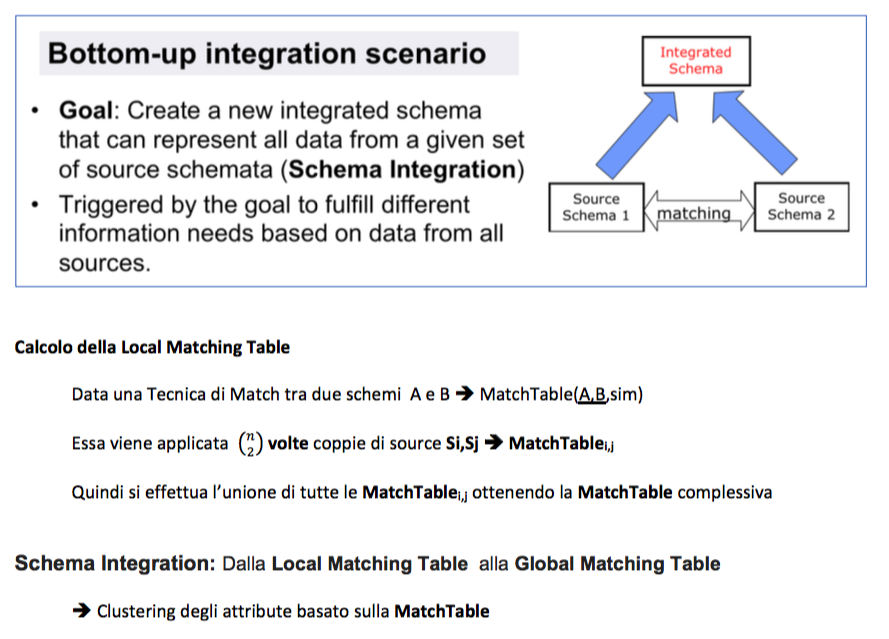

## Connected Component (Transitive Closure)

A connected component, of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph.

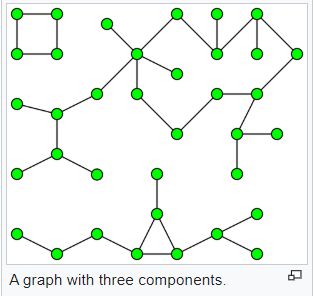

An alternative way to define components involves the equivalence classes of an equivalence relation that is defined on the vertices of the graph. In an undirected graph, a vertex v is reachable from a vertex u if there is a path from u to v. In this definition, a single vertex is counted as a path of length zero, and the same vertex may occur more than once within a path. Reachability is an equivalence relation, since:

* It is **reflexive**: There is a trivial path of length zero from any vertex to itself.

* It is **symmetric**: If there is a path from u to v, the same edges form a path from v to u.

* It is **transitive**: If there is a path from u to v and a path from v to w, the two paths may be concatenated together to form a path from u to w.

The components are then the induced subgraphs formed by the equivalence classes of this relation.



Si potrebbe utilizzare un algoritmo già sviluppato, ad esempio l'algoritmo  in
https://stackoverflow.com/questions/10301000/python-connected-components


Un'altra soluzione 
è quella di calcolare la Reflexive, Symmetric  and Transitive Closure di una relazione binaria, ovvero della MatchTable e poi effettuare un  raggruppamento. 




In [33]:
SOURCES = {}
SOURCES['S1'] = pd.DataFrame(columns=['A','B'])
SOURCES['S2'] = pd.DataFrame(columns=['C'])
SOURCES['S3'] = pd.DataFrame(columns=['D'])

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES:
  for y in SOURCES[x].columns:
    LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]
LAT

,SOURCE,LAT,SLAT
0,S1,A,S1_A
1,S1,B,S1_B
2,S2,C,S2_C
3,S3,D,S3_D


In [34]:
MatchTable=pd.DataFrame({'A': ['S1_A','S1_B'], 'B' : ['S1_B','S3_D'], 'sim' : [0.7, 0.5]})
MatchTable

,A,B,sim
0,S1_A,S1_B,0.7
1,S1_B,S3_D,0.5


In [35]:
def transitive_closure(a):
    closure = set(a)
    while True:
        new_relations = set((x,w) for x,y in closure for q,w in closure if q == y)
        closure_until_now = closure | new_relations # UNION
        if closure_until_now == closure:
            break
        closure = closure_until_now
    return closure

In [36]:
transitive_closure({(1,2),(2,3),(3,1)})

{(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)}

In [37]:
transitive_closure([(x[0],x[1]) for x in MatchTable.values.tolist()])

{('S1_A', 'S1_B'), ('S1_A', 'S3_D'), ('S1_B', 'S3_D')}

In [38]:
# Trasformo in un dataframe
X=transitive_closure([(x[1],x[0]) for x in MatchTable.values.tolist()])
TRANSITIVE_CLOSURE=pd.DataFrame(data=list(X),      columns=['A','B'])
TRANSITIVE_CLOSURE

,A,B
0,S3_D,S1_A
1,S1_B,S1_A
2,S3_D,S1_B


In [39]:
# per ottenere quello simmetrico, scambio attributi 
SYMMETRIC=TRANSITIVE_CLOSURE[['B','A']]
SYMMETRIC=SYMMETRIC.rename(columns={'B':'A','A':'B'})
SYMMETRIC

,A,B
0,S1_A,S3_D
1,S1_A,S1_B
2,S1_B,S3_D


In [40]:
# quindi unisco
SYMMETRIC_TRANSITIVE_CLOSURE=TRANSITIVE_CLOSURE.append(SYMMETRIC, ignore_index=True)
SYMMETRIC_TRANSITIVE_CLOSURE

,A,B
0,S3_D,S1_A
1,S1_B,S1_A
2,S3_D,S1_B
3,S1_A,S3_D
4,S1_A,S1_B
5,S1_B,S3_D


In [41]:
#  coppie riflessive
# attenzione: per tutti gli attributi, quindi devi considerare LAT
DA=LAT[['SLAT']].drop_duplicates()
REFLEXIVE_CLOSURE=pd.DataFrame({'A': LAT['SLAT'].drop_duplicates().to_list() , 'B': LAT['SLAT'].drop_duplicates().to_list() })
REFLEXIVE_CLOSURE

,A,B
0,S1_A,S1_A
1,S1_B,S1_B
2,S2_C,S2_C
3,S3_D,S3_D


In [42]:
# unisco tutto
REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE=SYMMETRIC_TRANSITIVE_CLOSURE.append(REFLEXIVE_CLOSURE, ignore_index=True)
REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE

,A,B
0,S3_D,S1_A
1,S1_B,S1_A
2,S3_D,S1_B
3,S1_A,S3_D
4,S1_A,S1_B
5,S1_B,S3_D
6,S1_A,S1_A
7,S1_B,S1_B
8,S2_C,S2_C
9,S3_D,S3_D


In [43]:
def ChiusuraRiflessivaTransitiva(MatchTable, LAT):
  def transitive_closure(a):
    closure = set(a)
    while True:
        new_relations = set((x,w) for x,y in closure for q,w in closure if q == y)
        closure_until_now = closure | new_relations
        if closure_until_now == closure:
            break
        closure = closure_until_now
    return closure

  X=transitive_closure([(x[1],x[0]) for x in MatchTable.values.tolist()])
  TRANSITIVE_CLOSURE=pd.DataFrame(data=list(X),      columns=['A','B'])
  TRANSITIVE_CLOSURE

  SYMMETRIC=TRANSITIVE_CLOSURE[['B','A']]
  SYMMETRIC=SYMMETRIC.rename(columns={'B':'A','A':'B'})
  SYMMETRIC_TRANSITIVE_CLOSURE=TRANSITIVE_CLOSURE.append(SYMMETRIC, ignore_index=True)

  DA=LAT[['SLAT']].drop_duplicates()
  REFLEXIVE_CLOSURE=pd.DataFrame({'A': LAT['SLAT'].drop_duplicates().to_list() , 
                                  'B': LAT['SLAT'].drop_duplicates().to_list() })

  REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE=SYMMETRIC_TRANSITIVE_CLOSURE.append(REFLEXIVE_CLOSURE, ignore_index=True)
  REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE


  return REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE

In [44]:
ChiusuraRiflessivaTransitiva(MatchTable,LAT)

,A,B
0,S3_D,S1_A
1,S1_B,S1_A
2,S3_D,S1_B
3,S1_A,S3_D
4,S1_A,S1_B
5,S1_B,S3_D
6,S1_A,S1_A
7,S1_B,S1_B
8,S2_C,S2_C
9,S3_D,S3_D


## Calcolo dei cluster
Il calcolo dei cluster si effettua tramite raggruppamento


In [45]:
MatchTableCRT=ChiusuraRiflessivaTransitiva(MatchTable,LAT)
CLUSTERS = MatchTableCRT.groupby('A').agg({'B': np.max}).reset_index()
CLUSTERS

,A,B
0,S1_A,S3_D
1,S1_B,S3_D
2,S2_C,S2_C
3,S3_D,S3_D


In [46]:
CLUSTERS.columns=['ClusterElement','ClusterKey']
CLUSTERS=CLUSTERS[['ClusterKey','ClusterElement']]
CLUSTERS.sort_values('ClusterKey')

,ClusterKey,ClusterElement
2,S2_C,S2_C
0,S3_D,S1_A
1,S3_D,S1_B
3,S3_D,S3_D


In [47]:
def CalcoloDeiCluster(MatchTableCRT):
    CLUSTERS = MatchTableCRT.groupby('A').agg({'B': np.max}).reset_index()
    CLUSTERS.columns=['ClusterElement','ClusterKey']
    CLUSTERS=CLUSTERS[['ClusterKey','ClusterElement']]


    return CLUSTERS.sort_values('ClusterKey')

In [48]:
CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable,LAT))

,ClusterKey,ClusterElement
2,S2_C,S2_C
0,S3_D,S1_A
1,S3_D,S1_B
3,S3_D,S3_D


In [49]:
CulsterOttenuti= CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable,LAT))
CulsterOttenuti = CulsterOttenuti.applymap(str)

def Aggregazione(x):    
      Campi = {
          'ClusterElement' :     x['ClusterElement'].str.cat(sep=',')
          }
      return pd.Series(Campi)
    
  
CulsterOttenuti.groupby('ClusterKey').apply(Aggregazione)

,ClusterElement
ClusterKey,
S2_C,S2_C
S3_D,"S1_A,S1_B,S3_D"


Per trasformare i cluster in una Global Matching Table:

In [50]:
X=CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable,LAT))

X = X.rename(columns={'ClusterKey': 'GAT',  'ClusterElement' : 'SLAT' })

def Estrai(x):
    x = x.split("_")
    return x[0]

def Estrai2(x):
    x = x.split("_")
    return x[1]

X['SOURCE']=X['SLAT'].map(Estrai)
X['LAT']=X['SLAT'].map(Estrai2)
X

,GAT,SLAT,SOURCE,LAT
2,S2_C,S2_C,S2,C
0,S3_D,S1_A,S1,A
1,S3_D,S1_B,S1,B
3,S3_D,S3_D,S3,D


In [51]:
LAT

,SOURCE,LAT,SLAT
0,S1,A,S1_A
1,S1,B,S1_B
2,S2,C,S2_C
3,S3,D,S3_D


In [52]:
to_GMM(X)

SOURCE,S1,S2,S3
GAT,,,
S2_C,[],[C],[]
S3_D,"[A, B]",[],[D]


## Esempio Bizer

In [53]:
# Esempio Bizer 
SOURCES = {}
SOURCES['S1'] = pd.DataFrame(columns=['ID','Name','Vorname','Alter'])
SOURCES['S2'] = pd.DataFrame(columns=['No','Name','FirstName','Age'])

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES:
  for y in SOURCES[x].columns:
    LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]
LAT

,SOURCE,LAT,SLAT
0,S1,ID,S1_ID
1,S1,Name,S1_Name
2,S1,Vorname,S1_Vorname
3,S1,Alter,S1_Alter
4,S2,No,S2_No
5,S2,Name,S2_Name
6,S2,FirstName,S2_FirstName
7,S2,Age,S2_Age


In [54]:
# GoldStandard_Bizer
VALORI = [
          ['A', 'B', ],
          ['S1_ID', 'S2_No'],
          ['S1_Name', 'S2_Name'],
          ['S1_Vorname', 'S2_FirstName'],
          ['S1_Alter', 'S2_Age'],
         ]
header = VALORI.pop(0)
GoldStandard_Bizer = pd.DataFrame(VALORI, columns=header)
GoldStandard_Bizer

,A,B
0,S1_ID,S2_No
1,S1_Name,S2_Name
2,S1_Vorname,S2_FirstName
3,S1_Alter,S2_Age


In [55]:
# Match Top1
VALORI = [
          ['A', 'B', ],
          ['S1_ID', 'S2_No'],
          ['S1_Name', 'S2_Name'],
          ['S1_Vorname', 'S2_Name'],
          ['S1_Alter', 'S2_Age'],
         ]
header = VALORI.pop(0)
MatchTable_Bizer = pd.DataFrame(VALORI, columns=header)
MatchTable_Bizer

,A,B
0,S1_ID,S2_No
1,S1_Name,S2_Name
2,S1_Vorname,S2_Name
3,S1_Alter,S2_Age


In [56]:
CulsterOttenuti= CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT))
CulsterOttenuti = CulsterOttenuti.applymap(str)

def Aggregazione(x):    
      Campi = {
          'ClusterElement' :     x['ClusterElement'].str.cat(sep=',')
          }
      return pd.Series(Campi)
    
  
CulsterOttenuti.groupby('ClusterKey').apply(Aggregazione)

,ClusterElement
ClusterKey,
S2_Age,"S1_Alter,S2_Age"
S2_FirstName,S2_FirstName
S2_Name,"S1_Name,S1_Vorname,S2_Name"
S2_No,"S1_ID,S2_No"


## Schema Integration:  dai cluster alla GMM

Dai cluster ottenuti si costruisce una 
 Global Matching Matrix (GMM) corrispondente, come visto in questo esempio: 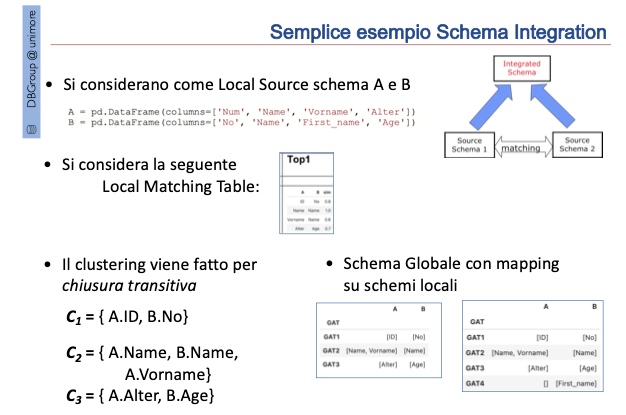




In [57]:
# Per ottenere GMM si calcola prima la GMT relativa 
def fromClusterToGMT(ClusterInput):
  X = ClusterInput.rename(columns={'ClusterKey': 'GAT',  'ClusterElement' : 'SLAT' })

  def Estrai(x):
    x = x.split("_")
    return x[0]

  def Estrai2(x):
    x = x.split("_")
    return x[1]

  X['SOURCE']=X['SLAT'].map(Estrai)
  X['LAT']=X['SLAT'].map(Estrai2)

  return X

In [58]:
fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT)))

,GAT,SLAT,SOURCE,LAT
0,S2_Age,S1_Alter,S1,Alter
4,S2_Age,S2_Age,S2,Age
5,S2_FirstName,S2_FirstName,S2,FirstName
2,S2_Name,S1_Name,S1,Name
3,S2_Name,S1_Vorname,S1,Vorname
6,S2_Name,S2_Name,S2,Name
1,S2_No,S1_ID,S1,ID
7,S2_No,S2_No,S2,No


In [59]:
# e quindi si trasforma in GMM
to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT))))

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[],[FirstName]
S2_Name,"[Name, Vorname]",[Name]
S2_No,[ID],[No]


In [60]:
# confrontiamola con quella del Gold Standard
to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(GoldStandard_Bizer,LAT))))

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[Vorname],[FirstName]
S2_Name,[Name],[Name]
S2_No,[ID],[No]


In [61]:
# Mettiamo tutto in una unica funzione
def SchemaIntegration(MatchTable:pd.DataFrame, LAT:pd.DataFrame):
  return to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable,LAT))))

In [62]:
SchemaIntegration(MatchTable_Bizer,LAT)

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[],[FirstName]
S2_Name,"[Name, Vorname]",[Name]
S2_No,[ID],[No]


In [63]:
# di seguito sono riassunte tutte le funzioni per calcolare i cluster 
# inoltre è stata aggiunta la funzione SchemaIntegration per ottenere direttamente la SchemaIntegration
def ChiusuraRiflessivaTransitiva(MatchTable, LAT):
  def transitive_closure(a):
    closure = set(a)
    while True:
        new_relations = set((x,w) for x,y in closure for q,w in closure if q == y)
        closure_until_now = closure | new_relations
        if closure_until_now == closure:
            break
        closure = closure_until_now
    return closure

  X=transitive_closure([(x[1],x[0]) for x in MatchTable.values.tolist()])
  TRANSITIVE_CLOSURE=pd.DataFrame(data=list(X),      columns=['A','B'])
  TRANSITIVE_CLOSURE

  SYMMETRIC=TRANSITIVE_CLOSURE[['B','A']]
  SYMMETRIC=SYMMETRIC.rename(columns={'B':'A','A':'B'})
  SYMMETRIC_TRANSITIVE_CLOSURE=TRANSITIVE_CLOSURE.append(SYMMETRIC, ignore_index=True)

  DA=LAT[['SLAT']].drop_duplicates()
  REFLEXIVE_CLOSURE=pd.DataFrame({'A': LAT['SLAT'].drop_duplicates().to_list() , 
                                  'B': LAT['SLAT'].drop_duplicates().to_list() })

  REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE=SYMMETRIC_TRANSITIVE_CLOSURE.append(REFLEXIVE_CLOSURE, ignore_index=True)
  REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE


  return REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE

def CalcoloDeiCluster(MatchTableCRT):
    CLUSTERS = MatchTableCRT.groupby('A').agg({'B': np.max}).reset_index()
    CLUSTERS.columns=['ClusterElement','ClusterKey']
    CLUSTERS=CLUSTERS[['ClusterKey','ClusterElement']]


    return CLUSTERS.sort_values('ClusterKey')
    
def fromClusterToGMT(ClusterInput):
  X = ClusterInput.rename(columns={'ClusterKey': 'GAT',  'ClusterElement' : 'SLAT' })

  def Estrai(x):
    x = x.split("_")
    return x[0]

  def Estrai2(x):
    x = x.split("_")
    return x[1]

  X['SOURCE']=X['SLAT'].map(Estrai)
  X['LAT']=X['SLAT'].map(Estrai2)

  return X

def SchemaIntegration(MatchTable:pd.DataFrame, LAT:pd.DataFrame):
  return to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable,LAT))))

In [64]:
MatchTable_Bizer

,A,B
0,S1_ID,S2_No
1,S1_Name,S2_Name
2,S1_Vorname,S2_Name
3,S1_Alter,S2_Age


In [65]:
SchemaIntegration(MatchTable_Bizer,LAT)

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[],[FirstName]
S2_Name,"[Name, Vorname]",[Name]
S2_No,[ID],[No]


In [66]:
GoldStandard_Bizer

,A,B
0,S1_ID,S2_No
1,S1_Name,S2_Name
2,S1_Vorname,S2_FirstName
3,S1_Alter,S2_Age


In [67]:
SchemaIntegration(GoldStandard_Bizer,LAT)

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[Vorname],[FirstName]
S2_Name,[Name],[Name]
S2_No,[ID],[No]


## Valutazione Cluster

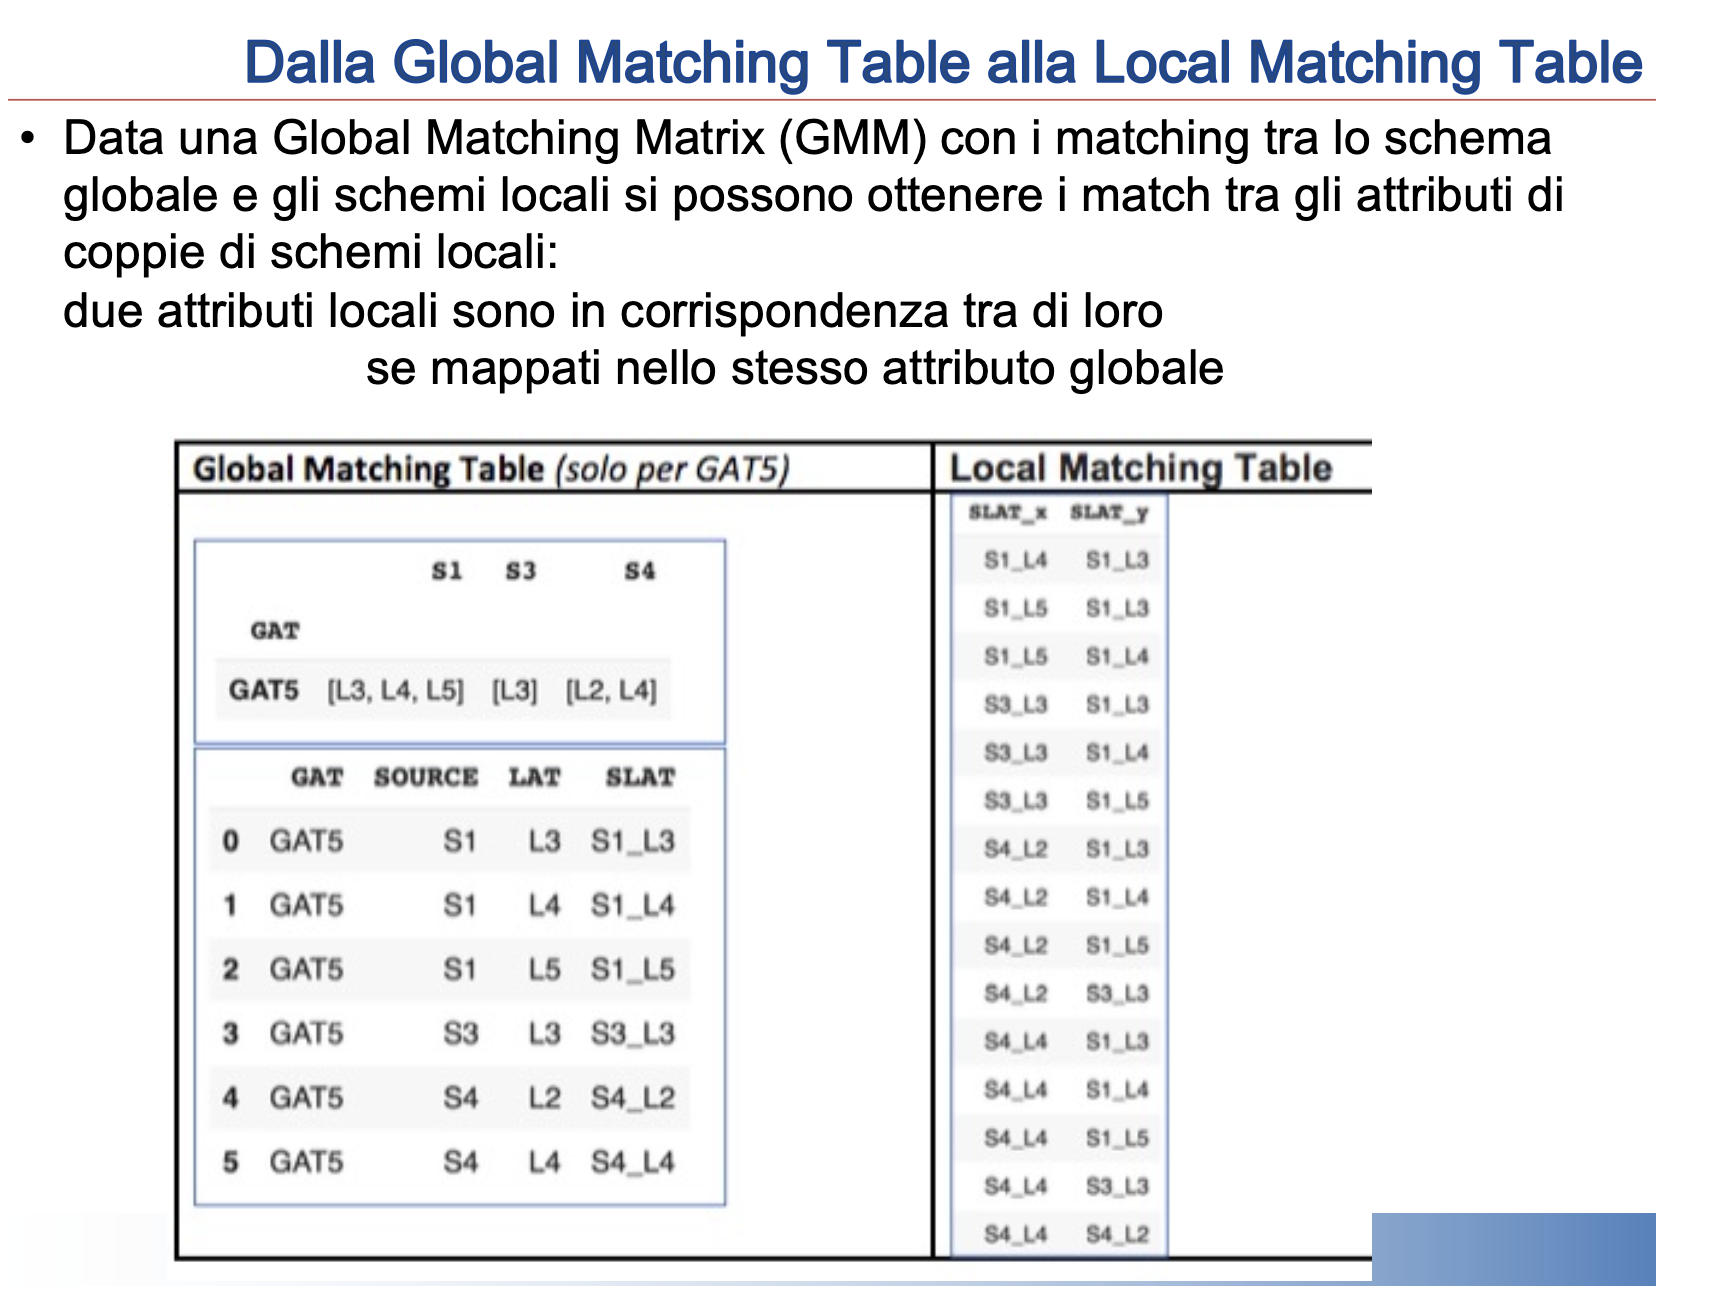

In [68]:
fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(GoldStandard_Bizer,LAT)))

,GAT,SLAT,SOURCE,LAT
0,S2_Age,S1_Alter,S1,Alter
4,S2_Age,S2_Age,S2,Age
3,S2_FirstName,S1_Vorname,S1,Vorname
5,S2_FirstName,S2_FirstName,S2,FirstName
2,S2_Name,S1_Name,S1,Name
6,S2_Name,S2_Name,S2,Name
1,S2_No,S1_ID,S1,ID
7,S2_No,S2_No,S2,No


In [69]:
GMM_GoldStandard=to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(GoldStandard_Bizer,LAT))))
GMM_GoldStandard

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[Vorname],[FirstName]
S2_Name,[Name],[Name]
S2_No,[ID],[No]


In [70]:
GMT_GoldStandard=to_GMT(GMM_GoldStandard)
GMT_GoldStandard

,GAT,SOURCE,LAT,SLAT
0,S2_Age,S1,Alter,S1_Alter
1,S2_Age,S2,Age,S2_Age
2,S2_FirstName,S1,Vorname,S1_Vorname
3,S2_FirstName,S2,FirstName,S2_FirstName
4,S2_Name,S1,Name,S1_Name
5,S2_Name,S2,Name,S2_Name
6,S2_No,S1,ID,S1_ID
7,S2_No,S2,No,S2_No


In [71]:
GMT_GoldStandard=to_GMT(GMM_GoldStandard)
GMT_GoldStandard

,GAT,SOURCE,LAT,SLAT
0,S2_Age,S1,Alter,S1_Alter
1,S2_Age,S2,Age,S2_Age
2,S2_FirstName,S1,Vorname,S1_Vorname
3,S2_FirstName,S2,FirstName,S2_FirstName
4,S2_Name,S1,Name,S1_Name
5,S2_Name,S2,Name,S2_Name
6,S2_No,S1,ID,S1_ID
7,S2_No,S2,No,S2_No


In [72]:
GMM=to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT))))
GMM

SOURCE,S1,S2
GAT,,
S2_Age,[Alter],[Age]
S2_FirstName,[],[FirstName]
S2_Name,"[Name, Vorname]",[Name]
S2_No,[ID],[No]


In [73]:
Join=pd.merge(GMT,GMT, on='GAT')
Join

,GAT,SOURCE_x,LAT_x,SLAT_x,sim_x,SOURCE_y,LAT_y,SLAT_y,sim_y
0,Age1,S1,Age1,S1_Age1,1.000000,S1,Age1,S1_Age1,1.000000
1,Age1,S1,Age1,S1_Age1,1.000000,S1,Age2,S1_Age2,0.833333
2,Age1,S1,Age1,S1_Age1,1.000000,S1,Name1,S1_Name1,0.783333
3,Age1,S1,Age1,S1_Age1,1.000000,S1,Name2,S1_Name2,0.633333
4,Age1,S1,Age1,S1_Age1,1.000000,S2,Age1,S2_Age1,1.000000
...,...,...,...,...,...,...,...,...,...
614,Age4,S3,Phone4,S3_Phone4,0.611111,S3,Phone4,S3_Phone4,0.611111
615,Other Phone,S2,Nome Completo,S2_Nome Completo,0.613442,S2,Nome Completo,S2_Nome Completo,0.613442
616,Other Phone,S2,Nome Completo,S2_Nome Completo,0.613442,S3,Nome Completo,S3_Nome Completo,0.613442
617,Other Phone,S3,Nome Completo,S3_Nome Completo,0.613442,S2,Nome Completo,S2_Nome Completo,0.613442


In [74]:
Join=Join[Join.SOURCE_x<Join.SOURCE_y]
Join

,GAT,SOURCE_x,LAT_x,SLAT_x,sim_x,SOURCE_y,LAT_y,SLAT_y,sim_y
4,Age1,S1,Age1,S1_Age1,1.000000,S2,Age1,S2_Age1,1.000000
5,Age1,S1,Age1,S1_Age1,1.000000,S2,Age3,S2_Age3,0.833333
6,Age1,S1,Age1,S1_Age1,1.000000,S2,Phone1,S2_Phone1,0.611111
7,Age1,S1,Age1,S1_Age1,1.000000,S2,gender,S2_gender,0.611111
8,Age1,S1,Age1,S1_Age1,1.000000,S3,Age4,S3_Age4,0.833333
...,...,...,...,...,...,...,...,...,...
563,Age4,S2,gender,S2_gender,0.611111,S3,Age4,S3_Age4,1.000000
564,Age4,S2,gender,S2_gender,0.611111,S3,Age2,S3_Age2,0.833333
565,Age4,S2,gender,S2_gender,0.611111,S3,gender,S3_gender,0.611111
566,Age4,S2,gender,S2_gender,0.611111,S3,Phone4,S3_Phone4,0.611111


In [75]:
Join=Join[['SLAT_x','SLAT_y']]
Join.columns=['A','B']
Join

,A,B
4,S1_Age1,S2_Age1
5,S1_Age1,S2_Age3
6,S1_Age1,S2_Phone1
7,S1_Age1,S2_gender
8,S1_Age1,S3_Age4
...,...,...
563,S2_gender,S3_Age4
564,S2_gender,S3_Age2
565,S2_gender,S3_gender
566,S2_gender,S3_Phone4


In [76]:
def MatchIndottiGMT(GMT):
  Join=pd.merge(GMT,GMT, on='GAT')
  Join=Join[Join.SOURCE_x<Join.SOURCE_y]
  Join=Join[['SLAT_x','SLAT_y']]
  Join.columns=['A','B']

  return Join.drop_duplicates()

In [77]:
MatchIndottiGMT(GMT_GoldStandard)

,A,B
1,S1_Alter,S2_Age
5,S1_Vorname,S2_FirstName
9,S1_Name,S2_Name
13,S1_ID,S2_No


In [78]:
GMT=fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT)))
GMT

,GAT,SLAT,SOURCE,LAT
0,S2_Age,S1_Alter,S1,Alter
4,S2_Age,S2_Age,S2,Age
5,S2_FirstName,S2_FirstName,S2,FirstName
2,S2_Name,S1_Name,S1,Name
3,S2_Name,S1_Vorname,S1,Vorname
6,S2_Name,S2_Name,S2,Name
1,S2_No,S1_ID,S1,ID
7,S2_No,S2_No,S2,No


In [79]:
Valuta(MatchIndottiGMT(GMT_GoldStandard),MatchIndottiGMT(GMT))

,MT,TP,FP,FN,P,R,F
0,4,3,1,1,0.75,0.75,0.75


In [80]:
Vedi_Valuta(MatchIndottiGMT(GMT_GoldStandard),MatchIndottiGMT(GMT),'FP')

,A,B,_merge
4,S1_Vorname,S2_Name,right_only


In [81]:
Vedi_Valuta(MatchIndottiGMT(GMT_GoldStandard),MatchIndottiGMT(GMT),'FN')

,A,B,_merge
1,S1_Vorname,S2_FirstName,left_only


In [82]:
ClusterMatching=CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT))
ClusterMatching

,ClusterKey,ClusterElement
0,S2_Age,S1_Alter
4,S2_Age,S2_Age
5,S2_FirstName,S2_FirstName
2,S2_Name,S1_Name
3,S2_Name,S1_Vorname
6,S2_Name,S2_Name
1,S2_No,S1_ID
7,S2_No,S2_No


In [83]:
ClusterGoldStandard=CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(GoldStandard_Bizer,LAT))
ClusterGoldStandard

,ClusterKey,ClusterElement
0,S2_Age,S1_Alter
4,S2_Age,S2_Age
3,S2_FirstName,S1_Vorname
5,S2_FirstName,S2_FirstName
2,S2_Name,S1_Name
6,S2_Name,S2_Name
1,S2_No,S1_ID
7,S2_No,S2_No


### MatchIndottiGMT & MatchIndottiCluster 

Nei notebook dello scorso anno, i match indotti venivano spesso calcolati direttamente sui cluster, con la seguente funzione,
ovviamente equivalente a MatchIndottiGMT

In [84]:
def MatchIndottiCluster(Cluster):
  def Estrai(x):
    x = x.split("_")
    return x[0]

  X=pd.merge(Cluster,Cluster, on='ClusterKey')
  X=X[['ClusterElement_x','ClusterElement_y']]
  X.columns=['A','B']
  X['SOURCE_A']=X['A'].map(Estrai)
  X['SOURCE_B']=X['B'].map(Estrai)
  X=X[X.SOURCE_A<X.SOURCE_B]
  return X

In [85]:
Valuta(MatchIndottiCluster(ClusterGoldStandard),MatchIndottiCluster(ClusterMatching))


,MT,TP,FP,FN,P,R,F
0,4,3,1,1,0.75,0.75,0.75


In [86]:
Vedi_Valuta(MatchIndottiCluster(ClusterGoldStandard),MatchIndottiCluster(ClusterMatching),'FP')


,A,B,SOURCE_A,SOURCE_B,_merge
4,S1_Vorname,S2_Name,NaN,NaN,right_only


# N sorgenti (vecchia versione)

Questo esempio fatto in classe è stato rifatto alla fine dopo aver sintetizzato le  funzioni 

In [ ]:
SOURCES={}
SOURCES['S1']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S1.csv').astype(str)
SOURCES['S2']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S2.csv').astype(str)
SOURCES['S3']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S3.csv').astype(str)

# Oppure
src_links = [
 'https://dbgroup.ing.unimore.it/SIWS/E1/S1.csv',
 'https://dbgroup.ing.unimore.it/SIWS/E1/S2.csv',
 'https://dbgroup.ing.unimore.it/SIWS/E1/S3.csv']

SOURCES = { 'S'+str(i+1) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES.keys():
    for y in SOURCES[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]

# Oppure
data = [[name,col, name+'_'+col] for name, df in SOURCES.items() for col in df.columns]
LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'],data=data)


In [ ]:
GoldStandard=pd.read_csv("https://dbgroup.ing.unimore.it/SIWS/E1/GoldStandardEsempioE1.csv").astype(str) 
to_GMM(GoldStandard)

SOURCE,S1,S2,S3
GAT,,,
Age1,[Age1],[Age1],[]
Age2,[Age2],[],[Age2]
Age4,[],[],[Age4]
Main Work Address (City),[City],[],[City1]
Main Work Address (Phone),[],[Phone1],[Phone1]
Name,[Name],[Full Name],[Full Name]
Other Phone,[Phone3],[],[Phone3]
Phone4City3,[Phone4],[City3],"[City3, Phone4]"
Secondary_Work_Address_City_Phone,[Phone2],[City2],[City2]


In [ ]:
def CalcoloGlobalMatchingTable(Sources:list, GlobalSchema:pd.DataFrame):
    GlobalMatchingTable = pd.DataFrame(columns=['GAT','SOURCE','LAT','SLAT','sim'])
    from tqdm import tqdm
    for y in tqdm(Sources.keys()):
        SimTableA = levenshtein_label_based_similarity(GlobalSchema, Sources[y])
        SimTableB = jaro_label_based_similarity(GlobalSchema, Sources[y])
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=value_overlap_simjoin_jaccard(GlobalSchema, Sources[y], 0.5)
        SimTable = avg_sim_table([SimTableA,SimTableB,SimTableB])
    
        MatchTable= thresholding(SimTable, 0.7)
        MatchTable = stable_marriage(MatchTable)
        #MatchTable = top_K(SimTable,2)
        #MatchTable = top_K(MatchTable,2)
        
        MatchTable.columns = ['GAT','LAT','sim']
        MatchTable['SOURCE'] = str(y)
        MatchTable['SLAT'] = MatchTable['SOURCE']+'_'+MatchTable['LAT']
        GlobalMatchingTable = GlobalMatchingTable.append(MatchTable, sort=False)
    return GlobalMatchingTable

In [ ]:
def CalcoloLocalMatchingTable(Sources:list):
    LocalMatchingTable = pd.DataFrame(columns=['SOURCE_A', 'LAT_A', 'SOURCE_B', 'LAT_B', 'SLAT_A', 'SLAT_B','sim'])
    from tqdm import tqdm
    
    for x in tqdm(Sources.keys()):
      for y in tqdm(Sources.keys()):
        if (x<y):

          
          LocalMatchingTableXY=levenshtein_label_based_similarity(Sources[x], Sources[y]) 
          LocalMatchingTableXY=thresholding(LocalMatchingTableXY,0.5)
          LocalMatchingTableXY.columns=['LAT_A','LAT_B','sim']
          LocalMatchingTableXY['SOURCE_A']=x
          LocalMatchingTableXY['SOURCE_B']=y
          LocalMatchingTableXY['SLAT_A']=LocalMatchingTableXY['SOURCE_A'] + '_' + LocalMatchingTableXY['LAT_A']
          LocalMatchingTableXY['SLAT_B']=LocalMatchingTableXY['SOURCE_B'] + '_' + LocalMatchingTableXY['LAT_B']
          LocalMatchingTable=LocalMatchingTable.append(LocalMatchingTableXY, sort=True)
    

    return LocalMatchingTable

In [ ]:
LMT=CalcoloLocalMatchingTable(SOURCES)

100%|██████████| 3/3 [00:00<00:00, 60.40it/s]

100%|██████████| 3/3 [00:00<00:00, 110.00it/s]

100%|██████████| 3/3 [00:00<00:00, 27.52it/s]


In [ ]:
LMT=LMT[['SLAT_A','SLAT_B']]
LMT.columns=['A','B']
LMT

,A,B
0,S1_rec_id,S2_rec_id
154,S1_X1,S2_X1
95,S1_Age1,S2_Age1
140,S1_gender2,S2_gender2
124,S1_Sex,S2_Sex
139,S1_gender2,S2_gender
81,S1_Phone4,S2_Phone1
68,S1_Phone3,S2_Phone1
55,S1_Phone2,S2_Phone1
41,S1_City1,S2_City2


In [ ]:
#fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(MatchTable_Bizer,LAT)))
to_GMM(fromClusterToGMT(CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(LMT,LAT))))

SOURCE,S1,S2,S3
GAT,,,
S1_X2,[X2],[],[]
S2_X3,[],[X3],[]
S3_Age2,[Name2],[],[Age2]
S3_Age4,"[Age1, Age2, Name1]","[Age3, Age1]",[Age4]
S3_City1,[],[],[City1]
S3_City2,[],[],[City2]
S3_City3,[City1],"[City3, City2]",[City3]
S3_Nome Completo,[],[Nome Completo],[Nome Completo]
S3_Phone1,[],[],[Phone1]


In [ ]:
GoldStandard.head()

,GAT,SOURCE,LAT,SLAT
0,rec_id,S1,rec_id,S1_rec_id
1,rec_id,S2,rec_id,S2_rec_id
2,rec_id,S3,rec_id,S3_rec_id
3,Name,S1,Name,S1_Name1
4,Name,S2,Full Name,S2_Nome Completo


In [ ]:
ClusterGoldStandard=CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(GoldStandard,LAT))
ClusterMatching=CalcoloDeiCluster(ChiusuraRiflessivaTransitiva(LMT,LAT))

In [ ]:
Valuta(MatchIndottiCluster(ClusterGoldStandard),MatchIndottiCluster(ClusterMatching))
GoldStandard.head()

,GAT,SOURCE,LAT,SLAT
0,rec_id,S1,rec_id,S1_rec_id
1,rec_id,S2,rec_id,S2_rec_id
2,rec_id,S3,rec_id,S3_rec_id
3,Name,S1,Name,S1_Name1
4,Name,S2,Full Name,S2_Nome Completo


In [ ]:
LMT.head()

,A,B
0,S1_rec_id,S2_rec_id
154,S1_X1,S2_X1
95,S1_Age1,S2_Age1
140,S1_gender2,S2_gender2
124,S1_Sex,S2_Sex


# Sintesi  processo di Bottom-Up Data Integration 



In [87]:
# Consideriamo il seguente esempio simbolico
S1= ['L1','L2']
S2= ['L1','L2','L3']
SOURCES = {}
SOURCES['S1'] = pd.DataFrame(columns=S1)
SOURCES['S2'] = pd.DataFrame(columns=S2)

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES:
  for y in SOURCES[x].columns:
    LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]
LAT

,SOURCE,LAT,SLAT
0,S1,L1,S1_L1
1,S1,L2,S1_L2
2,S2,L1,S2_L1
3,S2,L2,S2_L2
4,S2,L3,S2_L3


In [88]:
# Nella Bottom-up integration Il Gold Standard è la Global Matching Matrix "perfetta" 
# che vogliamo ottenere dal nostro processo 
# Inziamo con il caso più semplice, ovvero il caso che chiameremo 1-1 dove per ogni Local Source L
#           un attributo globale è mappato in un solo   attributo local di L, e viceversa
GMM_gold1_1 = pd.DataFrame({'GAT': ['GAT1', 'GAT2', 'GAT3'],
'S1': [[],['L1'],['L2']] ,
'S2': [['L1'],['L2'],['L3']] })
GMM_gold1_1=GMM_gold1_1.set_index(['GAT'])
GMM_gold1_1

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,[L1],[L2]
GAT3,[L2],[L3]


In [89]:
# Nel il caso 1-N dove per ogni Local Source L
#           un attributo globale è mappato in più attributi locali di L,  
#   ma NON viceversa, cioè un attributo di L è mappato in un solo attributo globale 
GMM_gold1_N = pd.DataFrame({'GAT': ['GAT1', 'GAT2', 'GAT3'],
'S1': [[],['L1'],['L2']] ,
'S2': [['L1'],[],['L3','L2']] })
GMM_gold1_N=GMM_gold1_N.set_index(['GAT'])
GMM_gold1_N

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,[L1],[]
GAT3,[L2],"[L3, L2]"


In [90]:
# Infine, il caso N-N dove per ogni Local Source L
#           un attributo globale è mappato in più attributi locali di L,  e viceversa
GMM_goldN_N = pd.DataFrame({'GAT': ['GAT1', 'GAT2', 'GAT3'],
'S1': [[],['L1','L2'],['L2']] ,
'S2': [['L1'],[],['L3','L2']] })
GMM_goldN_N=GMM_goldN_N.set_index(['GAT'])
GMM_goldN_N

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,"[L1, L2]",[]
GAT3,[L2],"[L3, L2]"


Con il processo di Schema Integration basato su Attribute Clustering, 
dove ogni attributo globale corrisponde ad un cluster ed i cluster sono disgiunti,
il caso N-N non potrà mai essere ottenuto come risultato.

In [91]:
# consideriamo il caso 1_1
GMM_gold1_1

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,[L1],[L2]
GAT3,[L2],[L3]


In [92]:
# Il Gold Standard viene dato come tabella ['GAT', 'SOURCE', 'LAT', 'SLAT'] quindi
Gold_Standard1_1=to_GMT(GMM_gold1_1)
Gold_Standard1_1

,GAT,SOURCE,LAT,SLAT
0,GAT1,S2,L1,S2_L1
1,GAT2,S1,L1,S1_L1
2,GAT2,S2,L2,S2_L2
3,GAT3,S1,L2,S1_L2
4,GAT3,S2,L3,S2_L3


In [93]:
# i match indotti da questo gold standard sono i seguenti
MatchIndottiGMT(Gold_Standard1_1)

,A,B
2,S1_L1,S2_L2
6,S1_L2,S2_L3


In [94]:
# Se effettuiamo lo Schema Integration tramite Attribute Clustering su tali match indotti
# riotteniamo esattamente la  Global Matching Matrix data all'inizio, cioè   Gold_Standard1_1 
SchemaIntegration(MatchIndottiGMT(Gold_Standard1_1),LAT)

SOURCE,S1,S2
GAT,,
S2_L1,[],[L1]
S2_L2,[L1],[L2]
S2_L3,[L2],[L3]


In [95]:
# Supponiamo che applicando lo schema matching  tra S1 ed S2 
# S1_L1	non viene messo in corrispondenza con S2_L2 ma con S2_L1 

MatchTable=MatchIndottiGMT(Gold_Standard1_1)
MatchTable.loc[(MatchTable['A'] == 'S1_L1')& (MatchTable['B'] == 'S2_L2'), 'B'] = 'S2_L1'
MatchTable

,A,B
2,S1_L1,S2_L1
6,S1_L2,S2_L3


In [96]:
# Se effettuiamo il processo di Schema Integration basato su clustering su tali match 
# otteniamo una   Global Matching Matrix  diversa da Gold_Standard1_1 
SchemaIntegration(MatchTable,LAT)

SOURCE,S1,S2
GAT,,
S2_L1,[L1],[L1]
S2_L2,[],[L2]
S2_L3,[L2],[L3]


In [97]:
# per confrontarlo con il Gold Standard dato:
GMM_gold1_1

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,[L1],[L2]
GAT3,[L2],[L3]


In [98]:
# si considerano le corrispondenze indotte da queste due Global Matching Matrix (GMM) 
# con la seguente semplice regola 
# due attributi locali sono in corrispondenza tra di loro se mappati nello stesso attributo globale

# nell'esempio è immediato verificare il risultato
MatchIndottiGMT(to_GMT(SchemaIntegration(MatchTable,LAT)))

,A,B
1,S1_L1,S2_L1
6,S1_L2,S2_L3


In [99]:
# effettuiamo la valutazione:
Valuta(MatchIndottiGMT(to_GMT(GMM_gold1_1)),
       MatchIndottiGMT(to_GMT(SchemaIntegration(MatchTable,LAT))))


,MT,TP,FP,FN,P,R,F
0,2,1,1,1,0.5,0.5,0.5


In [100]:
# Ricordiamo che la MatchTable era stata ottenuta dal Gold Standard nel seguente modo 
# S1_L1	non viene messo in corrispondenza con S2_L2 ma con S2_L1 
# quindi si è generato il seguente Falso Negativo:

Vedi_Valuta(MatchIndottiGMT(to_GMT(GMM_gold1_1)),
       MatchIndottiGMT(to_GMT(SchemaIntegration(MatchTable,LAT))),'FN')


,A,B,_merge
0,S1_L1,S2_L2,left_only


In [101]:
# e il seguente Falso Positivo:
Vedi_Valuta(MatchIndottiGMT(to_GMT(GMM_gold1_1)),
       MatchIndottiGMT(to_GMT(SchemaIntegration(MatchTable,LAT))),'FP')

,A,B,_merge
2,S1_L1,S2_L1,right_only


In [102]:
# ripetiamo le stesse considerazioni per il caso 1_N
GMM_gold1_N

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,[L1],[]
GAT3,[L2],"[L3, L2]"


In [103]:
# Il Gold Standard viene dato come tabella ['GAT', 'SOURCE', 'LAT', 'SLAT'] quindi
Gold_Standard1_N=to_GMT(GMM_gold1_N)
Gold_Standard1_N

,GAT,SOURCE,LAT,SLAT
0,GAT1,S2,L1,S2_L1
1,GAT2,S1,L1,S1_L1
2,GAT3,S1,L2,S1_L2
3,GAT3,S2,L3,S2_L3
4,GAT3,S2,L2,S2_L2


In [104]:
# i match indotti da questo gold standard sono i seguenti
MatchIndottiGMT(Gold_Standard1_N)

,A,B
3,S1_L2,S2_L3
4,S1_L2,S2_L2


In [105]:
# Cosa manca? le corrispondenze tra attributi della stessa Local Source S2 !!

In [106]:
def MatchIndottiGMT(GMT):
  Join=pd.merge(GMT,GMT, on='GAT')
#  Join=Join[Join.SOURCE_x<=Join.SOURCE_y]
  Join=Join[Join.SLAT_x<Join.SLAT_y]
  Join=Join[['SLAT_x','SLAT_y']]
  Join.columns=['A','B']

  return Join.drop_duplicates()

In [107]:
# i match indotti da questo gold standard sono i seguenti
MatchIndottiGMT(Gold_Standard1_N)

,A,B
3,S1_L2,S2_L3
4,S1_L2,S2_L2
9,S2_L2,S2_L3


In [108]:
# supponiamo che applicando lo schema matching  tra S1 ed S2 
# S1_L2	non viene messo in corrispondenza con S2_L2 
MatchTable=MatchIndottiGMT(Gold_Standard1_N)
MatchTable=MatchTable.drop(MatchTable[(MatchTable['A'] == 'S1_L2')& (MatchTable['B'] == 'S2_L2')].index  )
MatchTable

,A,B
3,S1_L2,S2_L3
9,S2_L2,S2_L3


In [109]:
SchemaIntegration(MatchTable,LAT)


SOURCE,S1,S2
GAT,,
S1_L1,[L1],[]
S2_L1,[],[L1]
S2_L3,[L2],"[L2, L3]"


In [110]:
# confrontiamola con Gold_Standard1_N
GMM_gold1_N

,S1,S2
GAT,,
GAT1,[],[L1]
GAT2,[L1],[]
GAT3,[L2],"[L3, L2]"


A parte ovviamente i nomi (e le posizioni) sono uguali!
Verifichiamolo con la valutazione dei match indotti

In [111]:
Valuta(MatchIndottiGMT(to_GMT(GMM_gold1_N)),
       MatchIndottiGMT(to_GMT(SchemaIntegration(MatchTable,LAT))))


,MT,TP,FP,FN,P,R,F
0,3,3,0,0,1.0,1.0,1.0


Perchè in questo caso sono uguali anche avendo tolto 
la corrispondenza S1_L2	 S2_L2  ??

# Funzioni per Data Integration


In entrambi i processi Top-Down Data Integration e Bottom Up Data Integration, l'**input** è un dizionario SOURCES = {} con le Local Sources. Le Local Sources sono sempre instanziate (ad eccezione degli esempi simbolici)

* Nel caso della Top-Down Data Integration, come input c'è anche un  Global  Schema ( Mediated Schema, Integrated Schema); 
Il Global Schema può essere virtuale oppure instanziato. 

In entrambi i processi Top-Down e Bottom Up, l'**output** è una
**Global Matching Matrix (GMM)** 

* Nel caso della Top-Down Data Integration, la Global Matching Matrix (GMM) ha come attributi globali tutti e soli quelli 
del Global  Schema dato. 

* Nel caso della Bottom-Up Data Integration, la Global Matching Matrix (GMM) ha un numero di attributi globali pari al numero di cluster derivanti dal processo di Schema Integration



## Funzioni generali

Funzioni che si applicano ad entrambi i processi



In [112]:
def to_GMT(MT:pd.DataFrame):
  GMT = pd.DataFrame(columns=['GAT','SOURCE', 'LAT','SLAT'])

  for x in MT.index:
    for y in MT.columns:
      for z in MT.loc[x][y]:
        GMT.loc[len(GMT)]=[x,y,z,str(y)+ '_' + z]
  return GMT

# con .fillna("[]")
def to_GMM(GMTA:pd.DataFrame):
    return GMTA.groupby(['GAT','SOURCE'])['LAT'].agg(list).unstack('SOURCE').fillna("[]")
# "funziona" to_GMM(to_GMT(GMM))
# ma non to_GMM(to_GMT(GMM))
#
# quindi usiamo 
def to_GMM(GMTA:pd.DataFrame):
    df = GMTA.groupby(['GAT','SOURCE'])['LAT'].agg(list).unstack('SOURCE')
    for c in df.columns:
        df.loc[df[c].isnull(), [c]] = df.loc[df[c].isnull(), c].apply(lambda x: [])
    return df

# per generare la Local Attribute Table 
def generaLAT(Sources):
  LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
  for x in Sources:
    for y in Sources[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]
  return LAT

## Funzioni per il processo Top-Down Data Integration

In sostanza nessuna nuova funzione, se non 
**CalcoloGlobalMatchingTable**
che applica un certo processo di Schema Matching a tutte le coppie
(Schema Locale, Schema Globale):

<code> def CalcoloGlobalMatchingTable(Sources:list, GlobalSchema:pd.DataFrame):</code>



In [113]:
def CalcoloGlobalMatchingTable(Sources:list, GlobalSchema:pd.DataFrame):
    GlobalMatchingTable = pd.DataFrame(columns=['GAT','SOURCE','LAT','SLAT','sim'])
    from tqdm import tqdm
    for y in tqdm(Sources.keys()):
        SimTableA = levenshtein_label_based_similarity(GlobalSchema, Sources[y])
        SimTableB = jaro_label_based_similarity(GlobalSchema, Sources[y])
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=value_overlap_simjoin_jaccard(GlobalSchema, Sources[y], 0.5)

        # combiner
        # SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])
    
        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.6)

        #MatchTable = top_K(SimTable,2)
        #MatchTable = top_K(MatchTable,2)
        
         # global mapping
        #MatchTable = stable_marriage(MatchTable)
#        MatchTable = simmetric_best_match(MatchTable)
     
        MatchTable.columns = ['GAT','LAT','sim']
        MatchTable['SOURCE'] = str(y)
        MatchTable['SLAT'] = MatchTable['SOURCE']+'_'+MatchTable['LAT']
        GlobalMatchingTable = GlobalMatchingTable.append(MatchTable, sort=False)
    return GlobalMatchingTable

# per estrarre le corrispondenze e rinominarle come (A,B) 
def toA_B(Y):
  X=Y[['GAT','SLAT']].rename(columns={'GAT':'A','SLAT':'B'})
  return X


## Funzioni per il processo Bottom-up Data Integration

In questo caso c'è la funzione **CalcoloLocalMatchingTable**

<code>
def CalcoloLocalMatchingTable(Sources:list):
</code>

che applica un certo processo di Schema Matching a tutte le coppie (Schema Locale_i, Schema Locale_j) degli schemi locali contenuti in Sources. In genere  si prendono tutte
le coppie (Schema Locale_i, Schema Locale_j)
con i  minore di j; però vedremo che è lecito anche considerare 
il caso i  minore o uguale di j


Oltre a CalcoloLocalMatchingTable
devo considerare anche tutte le funzioni per effettuare la clusterizzazione degli attributi



In [114]:
def CalcoloLocalMatchingTable(Sources:list):
    LocalMatchingTable = pd.DataFrame(columns=['SOURCE_A', 'LAT_A', 'SOURCE_B', 'LAT_B', 'SLAT_A', 'SLAT_B','sim'])
    from tqdm import tqdm
    
    for x in tqdm(Sources.keys()):
      for y in tqdm(Sources.keys()):
        if (x<y): # oppure x<= y per calcolare anche i matching tra una sorgente e se stessa
          # QUI SI PUO' RIPETERE TUTTO IL PROCESSO DI SCHEMA MATCHING RIPORTATO in CalcoloGlobalMatchingTable
          # sostituendo GlobalSchema con Sources[x]
          # ad esempio
          LocalMatchingTableXY=levenshtein_label_based_similarity(Sources[x], Sources[y]) 
          LocalMatchingTableXY=thresholding(LocalMatchingTableXY,0.5)

          # si ottiene LocalMatchingTableXY , si rinominano gli attributi
          LocalMatchingTableXY.columns=['LAT_A','LAT_B','sim']
          # si aggiungono i 2nomi" x e y delle Local Sources matchate 
          LocalMatchingTableXY['SOURCE_A']=x
          LocalMatchingTableXY['SOURCE_B']=y
          # e anche i SLAT
          LocalMatchingTableXY['SLAT_A']=LocalMatchingTableXY['SOURCE_A'] + '_' + LocalMatchingTableXY['LAT_A']
          LocalMatchingTableXY['SLAT_B']=LocalMatchingTableXY['SOURCE_B'] + '_' + LocalMatchingTableXY['LAT_B']
          # per poi aggiungerlo alla LocalMatchingTable complessiva
          LocalMatchingTable=LocalMatchingTable.append(LocalMatchingTableXY, sort=True)
    return LocalMatchingTable

In [115]:
# di seguito sono riassunte tutte le funzioni per calcolare i cluster 
def ChiusuraRiflessivaTransitiva(MatchTable, LAT):
  def transitive_closure(a):
    closure = set(a)
    while True:
        new_relations = set((x,w) for x,y in closure for q,w in closure if q == y)
        closure_until_now = closure | new_relations
        if closure_until_now == closure:
            break
        closure = closure_until_now
    return closure

  X=transitive_closure([(x[1],x[0]) for x in MatchTable.values.tolist()])
  TRANSITIVE_CLOSURE=pd.DataFrame(data=list(X),      columns=['A','B'])
  TRANSITIVE_CLOSURE

  SYMMETRIC=TRANSITIVE_CLOSURE[['B','A']]
  SYMMETRIC=SYMMETRIC.rename(columns={'B':'A','A':'B'})
  SYMMETRIC_TRANSITIVE_CLOSURE=TRANSITIVE_CLOSURE.append(SYMMETRIC, ignore_index=True)

  DA=LAT[['SLAT']].drop_duplicates()
  REFLEXIVE_CLOSURE=pd.DataFrame({'A': LAT['SLAT'].drop_duplicates().to_list() , 
                                  'B': LAT['SLAT'].drop_duplicates().to_list() })

  REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE=SYMMETRIC_TRANSITIVE_CLOSURE.append(REFLEXIVE_CLOSURE, ignore_index=True)
  REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE


  return REFLEXIVE_SYMMETRIC_TRANSITIVE_CLOSURE

def CalcoloDeiCluster(MatchTableCRT):
    CLUSTERS = MatchTableCRT.groupby('A').agg({'B': np.max}).reset_index()
    CLUSTERS.columns=['ClusterElement','ClusterKey']
    CLUSTERS=CLUSTERS[['ClusterKey','ClusterElement']]


    return CLUSTERS.sort_values('ClusterKey')
    
def fromClusterToGMT(ClusterInput):
  X = ClusterInput.rename(columns={'ClusterKey': 'GAT',  'ClusterElement' : 'SLAT' })

  def Estrai(x):
    x = x.split("_")
    return x[0]

  def Estrai2(x):
    x = x.split("_")
    return x[1]

  X['SOURCE']=X['SLAT'].map(Estrai)
  X['LAT']=X['SLAT'].map(Estrai2)

  return X  

In [116]:
# La seguente funzione SchemaIntegration contiene tutti i passi per ottenere la GMM
# a partire da un insieme di Sources 
def SchemaIntegration(Sources):
  X=ChiusuraRiflessivaTransitiva(CalcoloLocalMatchingTable(SOURCES)[['SLAT_A','SLAT_B']],generaLAT(SOURCES)).drop_duplicates()
  return to_GMM(fromClusterToGMT(CalcoloDeiCluster(X)))


## Valutazione

In entrambi i processi Top-Down e Bottom Up, l'**output** è una
**Global Matching Matrix (GMM)** 

Quindi in sostanza in entrambi i casi il Gold Standard è una GMM
(come discusso in precedenza per il processo di Bottom-Up)
ed in entrambi i casi quello che viene valutato sono i match indotti da tale GMM che vengono calcolati sulla relativa GMT dalla seguente funzione:

In [117]:
def MatchIndottiGMT(GMT):
  Join=pd.merge(GMT,GMT, on='GAT')
#  Join=Join[Join.SOURCE_x<=Join.SOURCE_y]
  Join=Join[Join.SLAT_x<Join.SLAT_y]
  Join=Join[['SLAT_x','SLAT_y']]
  Join.columns=['A','B']

  return Join.drop_duplicates()

# N Sorgenti - nuova versione

Esempio di Bottom-Up Integration

In [ ]:
SOURCES={}
SOURCES['S1']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S1.csv').astype(str)
SOURCES['S2']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S2.csv').astype(str)
SOURCES['S3']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S3.csv').astype(str)

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES.keys():
    for y in SOURCES[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]

In [ ]:
# useremo nel seguito generaLAT(SOURCES)
generaLAT(SOURCES).sample()

,SOURCE,LAT,SLAT
1,S1,Name1,S1_Name1


In [ ]:
GoldStandard=pd.read_csv("https://dbgroup.ing.unimore.it/SIWS/E1/GoldStandardEsempioE1.csv").astype(str) 
to_GMM(GoldStandard)

SOURCE,S1,S2,S3
GAT,,,
Age1,[Age1],[Age1],[]
Age2,[Age2],[],[Age2]
Age4,[],[],[Age4]
Main Work Address (City),[City],[],[City1]
Main Work Address (Phone),[],[Phone1],[Phone1]
Name,[Name],[Full Name],[Full Name]
Other Phone,[Phone3],[],[Phone3]
Phone4City3,[Phone4],[City3],"[City3, Phone4]"
Secondary_Work_Address_City_Phone,[Phone2],[City2],[City2]


In [ ]:
def CalcoloLocalMatchingTable(Sources:list):
    LocalMatchingTable = pd.DataFrame(columns=['SOURCE_A', 'LAT_A', 'SOURCE_B', 'LAT_B', 'SLAT_A', 'SLAT_B','sim'])
    from tqdm import tqdm
    
    for x in tqdm(Sources.keys()):
      for y in tqdm(Sources.keys()):
        if (x<y): # oppure x<= y per calcolare anche i matching tra una sorgente e se stessa
          # QUI SI PUO' RIPETERE TUTTO IL PROCESSO DI SCHEMA MATCHING RIPORTATO in CalcoloGlobalMatchingTable
          # sostituendo GlobalSchema con Sources[x]
          SimTableA = levenshtein_label_based_similarity(Sources[x], Sources[y])
          SimTableB = jaro_label_based_similarity(Sources[x], Sources[y])
          #SimTableB = value_overlap_sim(Sources[x], Sources[y])
          #SimTableC=value_overlap_simjoin_jaccard(Sources[x], Sources[y], 0.3)

          # combiner
          # SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])
          # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
          SimTable = avg_sim_table([SimTableA,SimTableB])
    
          # dalla tabella di similarità alle corrispondenze

          MatchTable= thresholding(SimTable, 0.7)

          #MatchTable = top_K(SimTable,2)
          #MatchTable = top_K(MatchTable,2)
        
         # global mapping
          #MatchTable = stable_marriage(MatchTable)
          #MatchTable = simmetric_best_match(MatchTable)


          #LocalMatchingTableXY=levenshtein_label_based_similarity(Sources[x], Sources[y]) 
          #LocalMatchingTableXY=thresholding(LocalMatchingTableXY,0.5)


          # si ottiene LocalMatchingTableXY , si rinominano gli attributi
          LocalMatchingTableXY=MatchTable
          LocalMatchingTableXY.columns=['LAT_A','LAT_B','sim']
          # si aggiungono i "nomi" x e y delle Local Sources matchate 
          LocalMatchingTableXY['SOURCE_A']=x
          LocalMatchingTableXY['SOURCE_B']=y
          # e anche i SLAT
          LocalMatchingTableXY['SLAT_A']=LocalMatchingTableXY['SOURCE_A'] + '_' + LocalMatchingTableXY['LAT_A']
          LocalMatchingTableXY['SLAT_B']=LocalMatchingTableXY['SOURCE_B'] + '_' + LocalMatchingTableXY['LAT_B']
          # per poi aggiungerlo alla LocalMatchingTable complessiva
          LocalMatchingTable=LocalMatchingTable.append(LocalMatchingTableXY, sort=True)

    return LocalMatchingTable

In [ ]:
GMM=SchemaIntegration(SOURCES)
GMM

100%|██████████| 3/3 [00:00<00:00, 37.36it/s]

100%|██████████| 3/3 [00:00<00:00, 15.14it/s]


SOURCE,S1,S2,S3
GAT,,,
S1_X2,[X2],[],[]
S2_X3,[],[X3],[]
S3_Age2,[Name2],[],[Age2]
S3_Age4,"[Age1, Age2, Name1]","[Age3, Age1]",[Age4]
S3_City1,[],[],[City1]
S3_City2,[],[],[City2]
S3_City3,[City1],"[City3, City2]",[City3]
S3_Nome Completo,[],[Nome Completo],[Nome Completo]
S3_Phone1,[],[],[Phone1]


In [ ]:
# effettuiamo la valutazione:
Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM)))

,MT,TP,FP,FN,P,R,F
0,51,4,47,18,0.0784,0.1818,0.1096


In [ ]:
# dataframe per memorizzare le valutazioni dei vari metodi
ValutazioneMatchTable = pd.DataFrame(columns=['MT', 'TP', 'FP', 'FN', 'P', 'R', 'F'])

In [ ]:
# 
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM))).rename(index={0: 'ProvaConAvg_06'}))
ValutazioneMatchTable


,MT,TP,FP,FN,P,R,F
ProvaConAvg_06,51,4,47,18,0.0784,0.1818,0.1096


In [ ]:
# Cosa accade applicando un global mapping tra le coppie di sorgenti in modo tale che si abbia tra di loro
# uno schema matching 1-1?

In [ ]:
# si deve aggiungere lo step
         # global mapping
          #MatchTable = stable_marriage(MatchTable)
#         MatchTable = simmetric_best_match(MatchTable)

# usando simmetric_best_match SBM

In [ ]:
# quindi dopo aver tolto  in SchemaIntegration  il # da MatchTable = simmetric_best_match(MatchTable)
GMM=SchemaIntegration(SOURCES)
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM))).rename(index={0: 'ProvaConAvg_06_SBM'}))
ValutazioneMatchTable


100%|██████████| 3/3 [00:00<00:00, 50.80it/s]

100%|██████████| 3/3 [00:00<00:00, 15.10it/s]


,MT,TP,FP,FN,P,R,F
ProvaConAvg_06,51,4,47,18,0.0784,0.1818,0.1096
ProvaConAvg_06_SBM,27,8,19,14,0.2963,0.3636,0.3265


In [ ]:
# commento
# il numero di match si dimezzano : da 51 a 27

In [ ]:
# usando  stable_marriage ?
GMM=SchemaIntegration(SOURCES)
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM))).rename(index={0: 'ProvaConAvg_06_SM'}))
ValutazioneMatchTable


100%|██████████| 3/3 [00:00<00:00, 34.11it/s]

100%|██████████| 3/3 [00:00<00:00, 11.06it/s]


,MT,TP,FP,FN,P,R,F
ProvaConAvg_06,51,4,47,18,0.0784,0.1818,0.1096
ProvaConAvg_06_SBM,27,8,19,14,0.2963,0.3636,0.3265
ProvaConAvg_06_SM,29,8,21,14,0.2759,0.3636,0.3137


In [ ]:
# perchè aumenta il numero di match ?

In [ ]:
# # aumentando la soglia a 0.7?

In [ ]:
GMM=SchemaIntegration(SOURCES)
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM))).rename(index={0: 'ProvaConAvg_07_SM'}))
ValutazioneMatchTable

100%|██████████| 3/3 [00:00<00:00,  6.24it/s]


,MT,TP,FP,FN,P,R,F
ProvaConAvg_06,51,4,47,18,0.0784,0.1818,0.1096
ProvaConAvg_06_SBM,27,8,19,14,0.2963,0.3636,0.3265
ProvaConAvg_06_SM,29,8,21,14,0.2759,0.3636,0.3137
ProvaConAvg_07_SM,29,8,21,14,0.2759,0.3636,0.3137


In [ ]:
# perchè resta invariato ? 
# per effetto dello stable marriage?
# proviam a toglierlo
GMM=SchemaIntegration(SOURCES)
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM))).rename(index={0: 'ProvaConAvg_07'}))
ValutazioneMatchTable

100%|██████████| 3/3 [00:00<00:00, 40.85it/s]

100%|██████████| 3/3 [00:00<00:00, 18.51it/s]


,MT,TP,FP,FN,P,R,F
ProvaConAvg_06,51,4,47,18,0.0784,0.1818,0.1096
ProvaConAvg_06_SBM,27,8,19,14,0.2963,0.3636,0.3265
ProvaConAvg_06_SM,29,8,21,14,0.2759,0.3636,0.3137
ProvaConAvg_07_SM,29,8,21,14,0.2759,0.3636,0.3137
ProvaConAvg_07,45,4,41,18,0.0889,0.1818,0.1194
